In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Adapted from: 
# lqr_neural_error_dynamics.ipynb

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# set the colormap and centre the colorbar
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [5]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\lqr'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
ext_list =['.png', '.eps']

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

#Pre-processing: 

bmi_b.preprocess_bmi_df(df, target_pos, pre, num_tasks, num_targets)
num_cw = 2
cw_label = ['cw', 'ccw']
task_rot_list = [0,1.1,1.2]

#Binning: 
#MAGNITUDE:
num_mag_bins = 5
num_mag_bins_analyze = 4
# mag_bin_perc = np.array([0,25,50,75,100])
mag_bin_perc = np.concatenate([np.linspace(0,95,5),np.array([100])])
#ANGLE:
num_angle_bins = 8
T0_angle = -3*(2*np.pi)/8
mag_bin, mag_bin_edges, mag_bin_c, angle_bin_c, angle_bin, angle_bin_edges =\
bmi_b.def_command_bin(df, mag_bin_perc, num_angle_bins, T0_angle)
#CENTER ANGLE DATA FOR BINNING (based on bin boundaries): 
angle_center_for_binning = bmi_b.df_center_angle_for_binning(df, angle_bin)
#BIN: 
bmi_b.df_bin_command(df, mag_bin_edges,angle_bin_edges)

#Pre-processing continued:

#Center angles to command bin, target: 
bmi_b.center_df_angle(df, angle_bin_c, target_angle)

True
('angle_center:', 22.5)
('min centered angle:', -157.47162455426732)
('max centered angle:', 202.46708261619673)


<IPython.core.display.Javascript object>


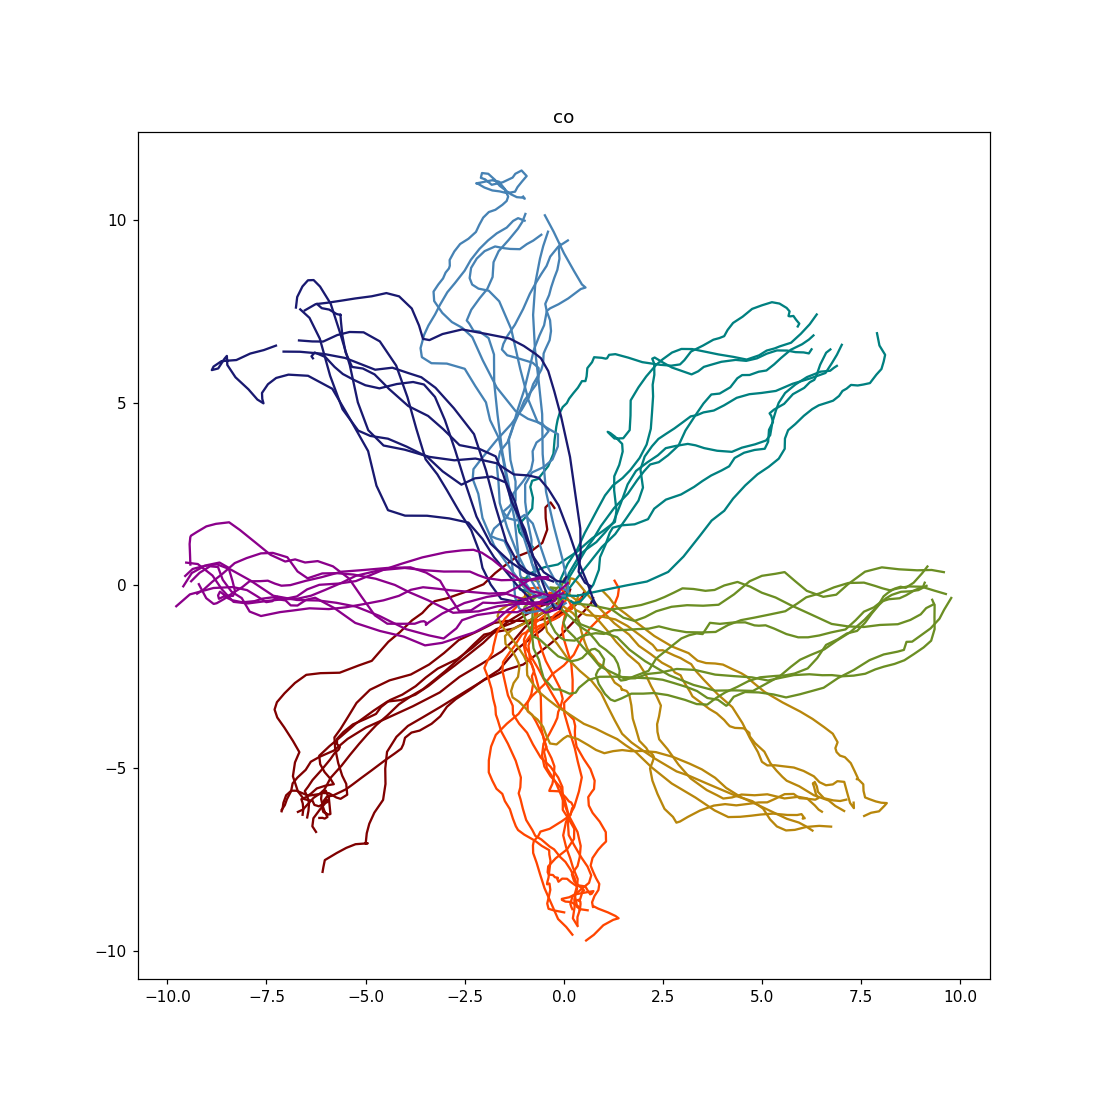

<IPython.core.display.Javascript object>


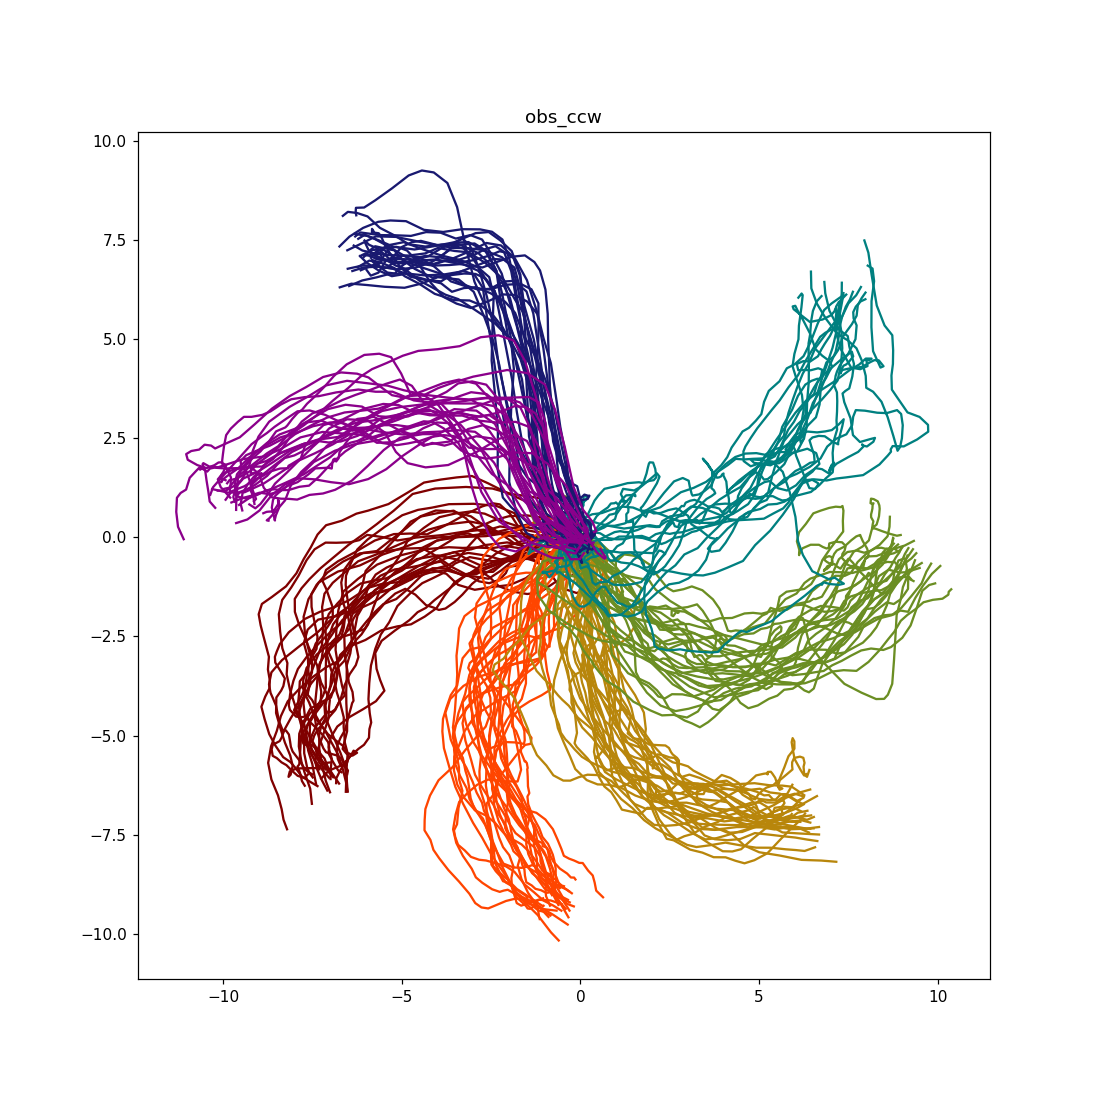

<IPython.core.display.Javascript object>


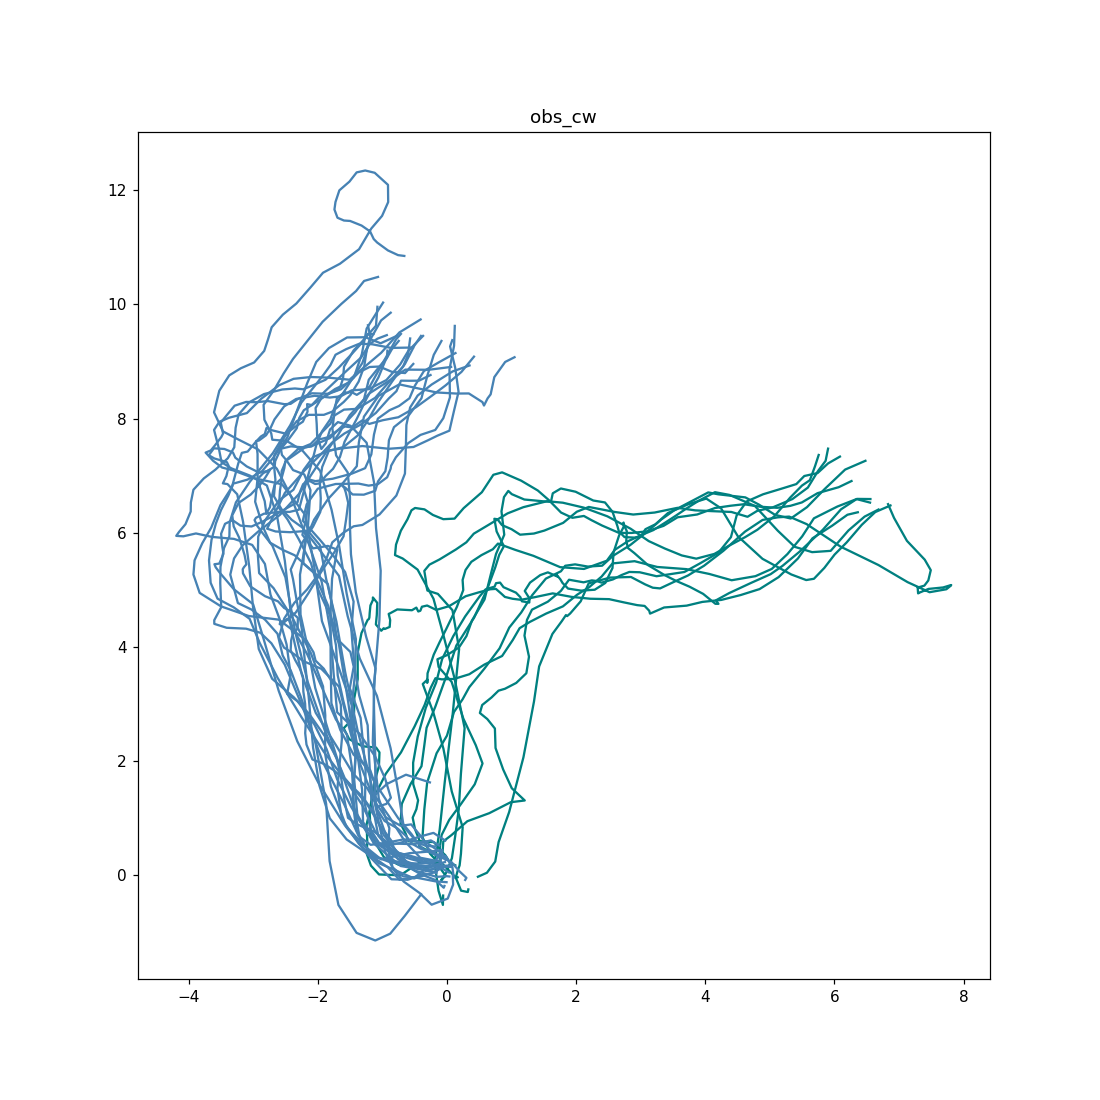

In [6]:
#Plot cw vs ccw trials, to confirm: 
plot = {}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)
task_rot_list = [0,1.1,1.2]
task_rot_label = ['co','obs_ccw', 'obs_cw']

for i,task in enumerate(task_rot_list):
    plt.figure(figsize=plot['size'])
    plt.title(task_rot_label[i])
    for target in range(num_targets):    
            sel = (df['task_rot']==task) & (df['bin']>=0) & (df['target']==target)
            df_sel = df[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

4704     115.0
4755     116.0
4796     117.0
4842     118.0
4890     119.0
4941     120.0
4988     121.0
5046     122.0
5122     123.0
5392     127.0
10206    238.0
Name: trial_global, dtype: float64


<IPython.core.display.Javascript object>


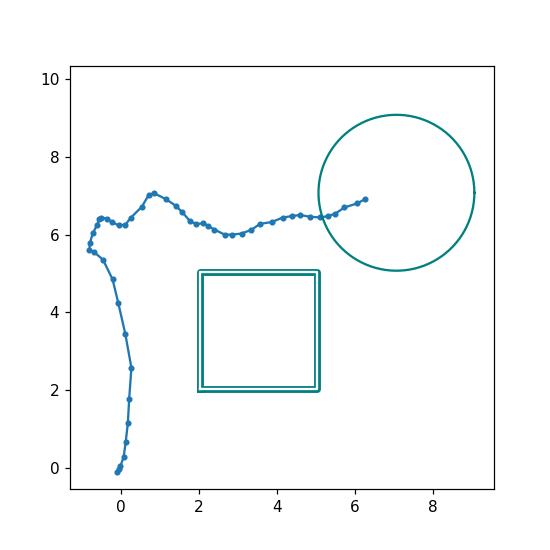

(-1.3012247717787875,
 9.564986506324725,
 -0.5427594616898825,
 10.32345181641363)

In [7]:
target = 4
sel_target = (df['target']==target)
sel_start = (df['bin']==0)
sel_task = (df['task_rot']==1.2) #1.2 is clockwise, 1.1 is counterclockwise
sel = sel_target&sel_start&sel_task
trials = df.loc[sel,'trial_global']
print(trials)

trial = int(trials.iloc[0])
sel_trial = (df['trial_global']==trial)
sel_bin = (df['bin']>=0)
sel = sel_trial&sel_bin

x = df.loc[sel, 'kin_px']
y = df.loc[sel, 'kin_py']

plt.figure(figsize=(5,5))
plt.plot(x,y, '.-')
c = target_color[target]
bmi_util.plot_obstacles(obs_pos[target,:].reshape((1,-1)), [c], obs_big*np.ones(1))
bmi_util.plot_targets(target_pos[target,:].reshape((1,-1)), [c], target_r_task[1]*np.ones(1))
plt.axis('square')

### Load noisy lqr sim data

In [ ]:
#Past analyzed files
# save_path = os.path.join(save_dir, 'lqr_noise_1000trials.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_1000trials_expt_noise_diag.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_20trials_noise_diag_expt_psth.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_1000trials_noise_diag_from_noiseless_n_null_lqr.pkl')

In [46]:
a = 'jeev'
d = str(0)
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_decoder_null.pkl')
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', a, d, 'lqr_sim_Q2_full.pkl')

# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')
df_lqr = df_lqr_n

In [27]:
df_lqr = df_lqr_n

In [21]:
r.keys()

['state_dim',
 'num_neurons',
 'Qv_s',
 'norm_u_df_nl',
 'noise_dic',
 'num_offset',
 'A_dic',
 'num_trials',
 'input_label',
 'obs_margin',
 'Qfp_s',
 'Q_f',
 'state_label',
 'move_lqr_nl',
 'kin_var',
 'num_kin',
 'Qfv_s',
 'bn_m',
 'df_lqr_nl',
 'df_lqr_n',
 'B',
 'task_rot_list',
 'F',
 'n_init_dic',
 'R_s',
 'Kn',
 'Q',
 'target_list',
 'R',
 'offset_var',
 'waypoint_speed',
 'An_m',
 'A_list',
 'center',
 'model_list',
 'move_lqr_n',
 'norm_u_df_n',
 'Qp_s',
 'm_noise',
 'n_list',
 'move_horizon']

<IPython.core.display.Javascript object>


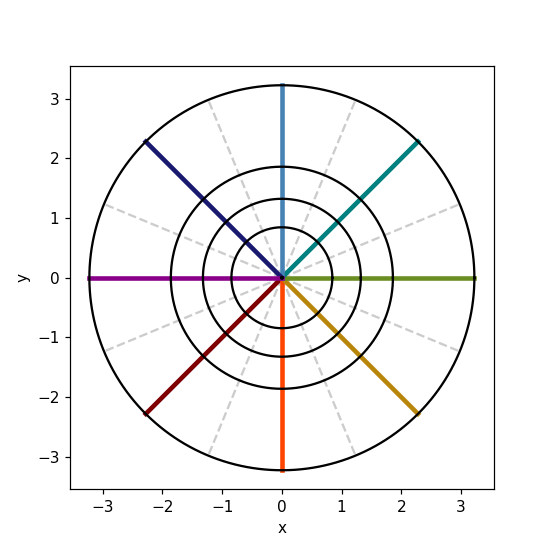

In [22]:
#TODO - this should show the command binning from the lqr...

num_mag_bins_analyze=4
def plot_command_bin(): 
    bmi_b.plot_polar_bins(angle_bin_edges, mag_bin_edges[:,:(num_mag_bins_analyze)], target_color)
    
plt.figure(figsize=(5,5))
plot_command_bin()    

In [23]:
save_dir

'D:\\Dropbox\\BMI_co_obs_paper\\data\\vivek\\lqr'

In [24]:
figname = m+'_' + str(num_trials_plot)+ 'ex_trials'
figname

'n_o_10ex_trials'

n_do


<IPython.core.display.Javascript object>


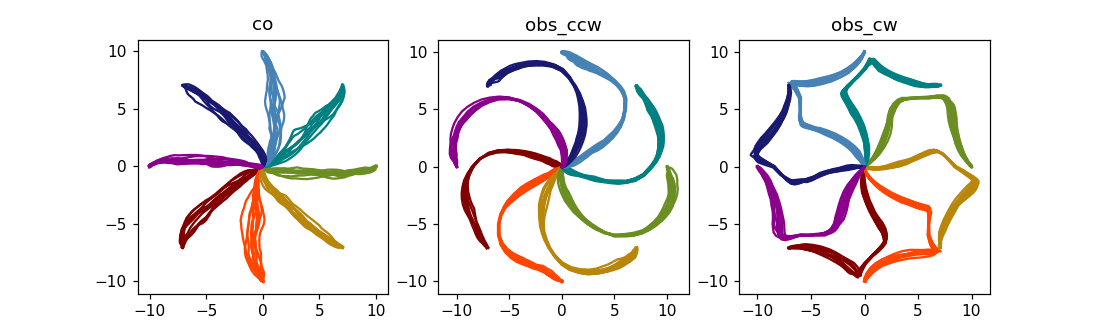

n_o


<IPython.core.display.Javascript object>


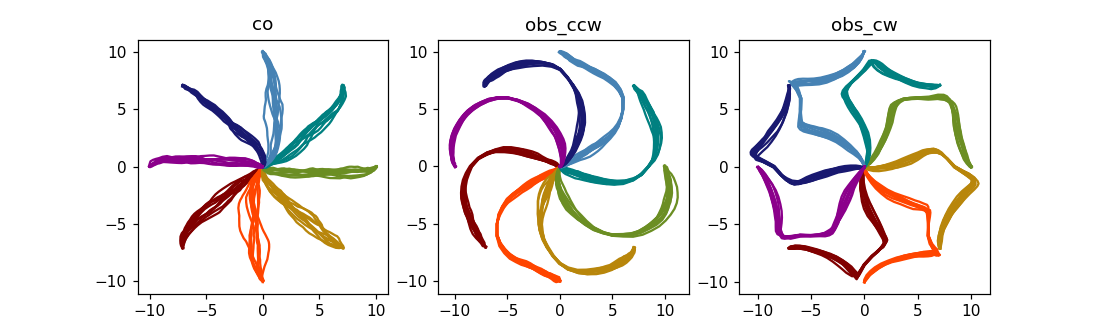

In [47]:
#Plot cw vs ccw trials, to confirm: 
for m in ['n_do', 'n_o']:
    print(m)
    
    num_trials_plot = 10
    save_bool = False
    fig_name = m+'_' + str(num_trials_plot)+ 'ex_trials'

    plot = {}
    plot['size'] = (10,3)
    plot['xlim'] = (-12.5,12.5)
    plot['ylim'] = (-12.5,12.5)
    task_rot_list = [0,1.1,1.2]
    task_rot_label = ['co','obs_ccw', 'obs_cw']



    plt.figure(figsize=plot['size'])
    for i,task in enumerate(task_rot_list): 
        plt.subplot(1,3,i+1)
        plt.title(task_rot_label[i])    
        for target in range(num_targets):    
            sel = (df_lqr['task_rot']==task) & (df_lqr['bin']>=0) & (df_lqr['target']==target) & (df_lqr['model'] == m)
            df_sel = df_lqr[sel]
            #------------------------------------------------------------------------------------
            #TRIALS: 
            trial_start = np.where(df_sel['bin']==0)[0]
            trial_stop = np.where(df_sel['bin_end']==0)[0]
            trial_bound = np.vstack((trial_start,trial_stop)).T
            #------------------------------------------------------------------------------------
            for bnd in trial_bound[:num_trials_plot,:]: #trial_bound[0:1,:]:
    #             if (task_str == 'co') or (task_str == 'obs') and (df_sel['obs_size'][bnd[0]:bnd[0]+1] == obs_big).bool(): 
                x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
                y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
                color = target_color[target]
                plt.plot(x,y,'-',color=color)

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))            

In [ ]:
### Norm u

In [ ]:
save_dir

In [34]:
norm_u_df_n

,norm_u,target,task,model
0,2.736996,0,0.0,n_do
1,2.752517,0,0.0,n_null
2,2.763901,0,0.0,n_o
3,2.780296,0,0.0,n_d
4,3.964209,0,1.1,n_do
5,3.957069,0,1.1,n_null
6,3.979116,0,1.1,n_o
7,4.010208,0,1.1,n_d
8,5.624208,0,1.2,n_do
9,5.575545,0,1.2,n_null


<IPython.core.display.Javascript object>


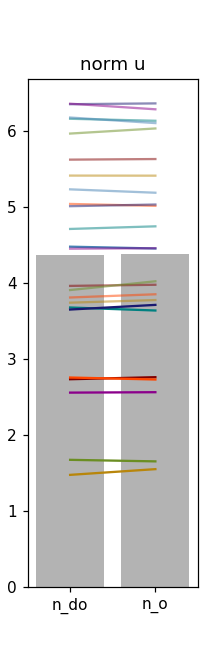

In [48]:
#Plot norm u for all movements: 
df_norm_lqr = norm_u_df_n
fig_name = 'norm_u'
save_bool = False

model_list = ['n_do', 'n_o']
task_alpha = {0:1, 1.1:0.5, 1.2:0.5}
plt.figure(figsize=(2,6))
u_m = {}
for m in model_list:
    u_m[m] = []
    
for target in range(num_targets):
    for task in task_rot_list:
        
        x_plot = []
        y_plot = []
        for i,m in enumerate(model_list):
            x_plot.append(i)
            sel = \
            (df_norm_lqr['target']==target)\
            &(df_norm_lqr['task']==task)\
            &(df_norm_lqr['model']==m)
            y_i = float(df_norm_lqr.loc[sel,'norm_u'])
            y_plot.append(y_i)
            
            u_m[m].append(y_i)
            
        plt.plot(x_plot,y_plot,color=target_color[target], alpha=task_alpha[task]) #label='target'+str(target)+'task'+str(task)

plt.xticks(range(len(model_list)), model_list)
plt.ylabel('norm u')
plt.title('norm u')
plt.xlim([-0.5,1.5])

#plot the 
for m in model_list:
    u_m[m,'mean'] = np.mean(u_m[m])
plt_bar = [u_m[model_list[0], 'mean'], u_m[model_list[1], 'mean']]
plt.bar([0,1], plt_bar, width=0.8, color=0.7*np.ones(3))


if save_bool:
    for ext in ext_list:
        plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
len(u_m['n_do'])

In [51]:
#check p-value: 
test = scipy.stats.wilcoxon(u_m['n_do'], u_m['n_o'])
test

WilcoxonResult(statistic=127.0, pvalue=0.5110890641174397)

### Analyze diff command-movement vs command

In [52]:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [53]:
#mean diff: 
df_diff_col = n_list + ['diff', 'diff_null', 'diff_potent', 'ba', 'bm', 'model', 'target', 'task_rot', 'num']
nan_df = pd.DataFrame()
df_diff = []
for ba in range(num_angle_bins):
    sel_ba = (df_lqr['u_v_angle_bin']==ba)
    sel_d_ba = (df_mean['ba'] == ba)    
    for bm in range(num_mag_bins_analyze):
        sel_bm = (df_lqr['u_v_mag_bin']==bm)
        sel_d_bm = (df_mean['bm'] == bm)
        for m in model_list:
            sel_m = (df_lqr['model'] == m)
            sel_d_m = (df_mean['model'] == m)
            sel_d = sel_d_ba&sel_d_bm&sel_d_m
            mean_i = df_mean.loc[sel_d, n_list]
            
            
            for task in task_rot_list:
                sel_task = (df_lqr['task_rot']==task)
                for target in range(num_targets):
                    sel_target = (df_lqr['target']==target)
                    
                    sel = sel_ba&sel_bm&sel_m&sel_task&sel_target
                    num = len(np.where(sel)[0])
                    if num > 0:
                        n_i = df_lqr.loc[sel,n_list].mean()
                        diff_i = n_i-mean_i
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        
                        df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_diff_col)))*np.nan, columns=df_diff_col))
                        df_i.loc[0,n_list]=n_i
                        df_i['diff']=np.linalg.norm(diff_i)
                        df_i['diff_null']=np.linalg.norm(diff_null_i)
                        df_i['diff_potent']=np.linalg.norm(diff_potent_i)
                        df_i['ba'] = ba
                        df_i['bm'] = bm
                        df_i['model'] = m
                        df_i['task_rot'] = task
                        df_i['target'] = target
                        df_i['num'] = num

                        df_diff.append(df_i)
df_diff = pd.concat(df_diff, ignore_index=True)   

NameError: name 'df_mean' is not defined

In [ ]:
# df_mean
# df_diff

In [ ]:
plt.figure(figsize=(5,5))

model_list = ['n_do', 'n_null']
model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}
d_cm_diff = []

diff_sel = 'diff' #'diff', 'diff_potent'

min_obs = 15
for i,m in enumerate(model_list):
    print(m)
    sel_m = df_diff['model']==m
    sel_obs = df_diff['num']>=min_obs
    
    sel = sel_m&sel_obs
#     sel = sel_m&sel_obs
    diff_i = df_diff.loc[sel, diff_sel]
    d_cm_diff.append(diff_i)
    diff_mean_i = df_diff.loc[sel, diff_sel].mean()
    print(m, diff_mean_i)
#     num = df_diff.loc[sel, 'num'].mean()
#     print(m, test, num)
    plt.scatter(i*np.ones(len(diff_i)), diff_i, alpha=0.3,color=model_color[m])
    plt.hlines(diff_mean_i, i-0.25,i+0.25)
    
_=plt.xticks([0,1], model_list)
plt.title(diff_sel+':'+' command-movement mean minus command mean')
plt.ylabel('norm difference of activity')
    

In [ ]:
#Histogram the diffs and plot overlapping distributions:
vmin = 0
vmax = 11
num_bins = (vmax-vmin)*10+1
cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = []
for i,d in enumerate(d_cm_diff):
    d = np.array(d).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned.append(hist_result)


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for i,d in enumerate(cm_diff_binned):
    m = model_list[i]
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot,color=model_color[m],label=m)
    
    d_mean = np.mean(d_cm_diff[i])
    plt.vlines(d_mean, 0, 0.15, color=model_color[m],alpha=0.2)
plt.xlim((-0.5,6))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('Dist bw command-movement and command activity')


In [ ]:
# #Let's loop and confirm there's no within bin difference: 
# #loop each command (get command distribution)
# #loop each movement (get cm distribution)
# #use t-test to compare x and y distribution

# model_list = ['n_do', 'n_null']
# df_t_col = ['diff_x', 'diff_y', 'xstat', 'xp', 'ystat', 'yp', 'ba', 'bm', 'model', 'task_rot', 'target', 'num_cm', 'num_c']
# df_t = []
# for ba in range(num_angle_bins):
#     sel_ba = (df_lqr['u_v_angle_bin']==ba)
#     for bm in range(num_mag_bins_analyze):
#         sel_bm = (df_lqr['u_v_mag_bin']==bm)
#         for m in model_list:
#             sel_m = (df_lqr['model'] == m)
#             sel_c = sel_ba&sel_bm&sel_m
#             cx = df_lqr.loc[sel_c, 'u_vx'] 
#             cy = df_lqr.loc[sel_c, 'u_vy'] 
#             num_c = len(np.where(sel_c)[0])
            
#             for task in task_rot_list:
#                 sel_task = (df_lqr['task_rot']==task)
#                 for target in range(num_targets):
#                     sel_target = (df_lqr['target']==target)
#                     sel_cm = sel_ba&sel_bm&sel_m&sel_task&sel_target
#                     cmx = df_lqr.loc[sel_cm, 'u_vx'] 
#                     cmy = df_lqr.loc[sel_cm, 'u_vy']                     
                    
#                     num_cm = len(np.where(sel_cm)[0])
#                     if num_cm > 0:
#                         print(ba, bm, m, task, target)
#                         xstat, xp = sio_stat.ttest_ind(cx, cmx)
#                         ystat, yp = sio_stat.ttest_ind(cy, cmy)
                        
#                         df_i = pd.DataFrame(pd.DataFrame(np.ones((1,len(df_t_col)))*np.nan, columns=df_t_col))
#                         df_i['diff_x']=cx.mean()-cmx.mean()
#                         df_i['diff_y']=cy.mean()-cmy.mean()
#                         df_i['xstat'] = xstat
#                         df_i['xp'] = xp
#                         df_i['ystat'] = ystat
#                         df_i['yp'] = yp
                        
#                         df_i['ba'] = ba
#                         df_i['bm'] = bm
#                         df_i['model'] = m
#                         df_i['task_rot'] = task
#                         df_i['target'] = target
#                         df_i['num_cm'] = num_cm
#                         df_i['num_c'] = num_c

#                         df_t.append(df_i)
# df_t = pd.concat(df_t, ignore_index=True)              

In [ ]:
df_t

### Check the distribution of commands for each type of movement

In [54]:
#Useful especially when splitting an obstacle movement into cw vs ccw.
move_list = []
for target in range(num_targets):
    for task in task_rot_list:
        move_list.append((target,task))
m_list = move_list #In case we prefer 
num_move = len(m_list)        
#List of commands in case it's useful    
c_list = [] #(bm,ba)
for bm in range(num_mag_bins_analyze):
    for ba in range(num_angle_bins):
        c_list.append((bm,ba))        
num_c = len(c_list)
#List of neurons:
n_list = ['n_'+str(i) for i in range(num_neurons)]

In [56]:
#Count the number of observations for each command for each movement:
t_start = timeit.default_timer()
cd = {} #command data
model_cm_dist = {}
model_list = ['n_do', 'n_o']
for model in model_list:
    sel_model = (df_lqr.loc[:,'model']==model)
    model_cm_dist[model] = xr.DataArray(np.zeros((num_move, num_c)),
                                       coords={'m':range(num_move),'c':range(num_c)},
                                       dims=['m','c'])
    for ic, c in enumerate(c_list):
        bm = c[0]
        ba = c[1]
        sel_c = (df_lqr.loc[:,'u_v_mag_bin']==bm)&(df_lqr.loc[:,'u_v_angle_bin']==ba)
        
        
        for im, m in enumerate(m_list):
            print(model, c, m)
            target = m[0]
            task = m[1]
            sel_m = (df_lqr.loc[:,'target']==target)&(df_lqr.loc[:,'task_rot']==task)
            
            sel = sel_model&sel_c&sel_m
            num_obs = sum(sel)
            model_cm_dist[model].loc[im, ic] = num_obs
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (0, 0), (0, 0))
('n_do', (0, 0), (0, 1.1))
('n_do', (0, 0), (0, 1.2))
('n_do', (0, 0), (1, 0))
('n_do', (0, 0), (1, 1.1))
('n_do', (0, 0), (1, 1.2))
('n_do', (0, 0), (2, 0))
('n_do', (0, 0), (2, 1.1))
('n_do', (0, 0), (2, 1.2))
('n_do', (0, 0), (3, 0))
('n_do', (0, 0), (3, 1.1))
('n_do', (0, 0), (3, 1.2))
('n_do', (0, 0), (4, 0))
('n_do', (0, 0), (4, 1.1))
('n_do', (0, 0), (4, 1.2))
('n_do', (0, 0), (5, 0))
('n_do', (0, 0), (5, 1.1))
('n_do', (0, 0), (5, 1.2))
('n_do', (0, 0), (6, 0))
('n_do', (0, 0), (6, 1.1))
('n_do', (0, 0), (6, 1.2))
('n_do', (0, 0), (7, 0))
('n_do', (0, 0), (7, 1.1))
('n_do', (0, 0), (7, 1.2))
('n_do', (0, 1), (0, 0))
('n_do', (0, 1), (0, 1.1))
('n_do', (0, 1), (0, 1.2))
('n_do', (0, 1), (1, 0))
('n_do', (0, 1), (1, 1.1))
('n_do', (0, 1), (1, 1.2))
('n_do', (0, 1), (2, 0))
('n_do', (0, 1), (2, 1.1))
('n_do', (0, 1), (2, 1.2))
('n_do', (0, 1), (3, 0))
('n_do', (0, 1), (3, 1.1))
('n_do', (0, 1), (3, 1.2))
('n_do', (0, 1), (4, 0))
('n_do', (0, 1), (4, 1.1))


('n_do', (1, 5), (2, 1.1))
('n_do', (1, 5), (2, 1.2))
('n_do', (1, 5), (3, 0))
('n_do', (1, 5), (3, 1.1))
('n_do', (1, 5), (3, 1.2))
('n_do', (1, 5), (4, 0))
('n_do', (1, 5), (4, 1.1))
('n_do', (1, 5), (4, 1.2))
('n_do', (1, 5), (5, 0))
('n_do', (1, 5), (5, 1.1))
('n_do', (1, 5), (5, 1.2))
('n_do', (1, 5), (6, 0))
('n_do', (1, 5), (6, 1.1))
('n_do', (1, 5), (6, 1.2))
('n_do', (1, 5), (7, 0))
('n_do', (1, 5), (7, 1.1))
('n_do', (1, 5), (7, 1.2))
('n_do', (1, 6), (0, 0))
('n_do', (1, 6), (0, 1.1))
('n_do', (1, 6), (0, 1.2))
('n_do', (1, 6), (1, 0))
('n_do', (1, 6), (1, 1.1))
('n_do', (1, 6), (1, 1.2))
('n_do', (1, 6), (2, 0))
('n_do', (1, 6), (2, 1.1))
('n_do', (1, 6), (2, 1.2))
('n_do', (1, 6), (3, 0))
('n_do', (1, 6), (3, 1.1))
('n_do', (1, 6), (3, 1.2))
('n_do', (1, 6), (4, 0))
('n_do', (1, 6), (4, 1.1))
('n_do', (1, 6), (4, 1.2))
('n_do', (1, 6), (5, 0))
('n_do', (1, 6), (5, 1.1))
('n_do', (1, 6), (5, 1.2))
('n_do', (1, 6), (6, 0))
('n_do', (1, 6), (6, 1.1))
('n_do', (1, 6), (6, 1.2)

('n_do', (3, 2), (6, 1.1))
('n_do', (3, 2), (6, 1.2))
('n_do', (3, 2), (7, 0))
('n_do', (3, 2), (7, 1.1))
('n_do', (3, 2), (7, 1.2))
('n_do', (3, 3), (0, 0))
('n_do', (3, 3), (0, 1.1))
('n_do', (3, 3), (0, 1.2))
('n_do', (3, 3), (1, 0))
('n_do', (3, 3), (1, 1.1))
('n_do', (3, 3), (1, 1.2))
('n_do', (3, 3), (2, 0))
('n_do', (3, 3), (2, 1.1))
('n_do', (3, 3), (2, 1.2))
('n_do', (3, 3), (3, 0))
('n_do', (3, 3), (3, 1.1))
('n_do', (3, 3), (3, 1.2))
('n_do', (3, 3), (4, 0))
('n_do', (3, 3), (4, 1.1))
('n_do', (3, 3), (4, 1.2))
('n_do', (3, 3), (5, 0))
('n_do', (3, 3), (5, 1.1))
('n_do', (3, 3), (5, 1.2))
('n_do', (3, 3), (6, 0))
('n_do', (3, 3), (6, 1.1))
('n_do', (3, 3), (6, 1.2))
('n_do', (3, 3), (7, 0))
('n_do', (3, 3), (7, 1.1))
('n_do', (3, 3), (7, 1.2))
('n_do', (3, 4), (0, 0))
('n_do', (3, 4), (0, 1.1))
('n_do', (3, 4), (0, 1.2))
('n_do', (3, 4), (1, 0))
('n_do', (3, 4), (1, 1.1))
('n_do', (3, 4), (1, 1.2))
('n_do', (3, 4), (2, 0))
('n_do', (3, 4), (2, 1.1))
('n_do', (3, 4), (2, 1.2)

('n_o', (1, 0), (6, 1.1))
('n_o', (1, 0), (6, 1.2))
('n_o', (1, 0), (7, 0))
('n_o', (1, 0), (7, 1.1))
('n_o', (1, 0), (7, 1.2))
('n_o', (1, 1), (0, 0))
('n_o', (1, 1), (0, 1.1))
('n_o', (1, 1), (0, 1.2))
('n_o', (1, 1), (1, 0))
('n_o', (1, 1), (1, 1.1))
('n_o', (1, 1), (1, 1.2))
('n_o', (1, 1), (2, 0))
('n_o', (1, 1), (2, 1.1))
('n_o', (1, 1), (2, 1.2))
('n_o', (1, 1), (3, 0))
('n_o', (1, 1), (3, 1.1))
('n_o', (1, 1), (3, 1.2))
('n_o', (1, 1), (4, 0))
('n_o', (1, 1), (4, 1.1))
('n_o', (1, 1), (4, 1.2))
('n_o', (1, 1), (5, 0))
('n_o', (1, 1), (5, 1.1))
('n_o', (1, 1), (5, 1.2))
('n_o', (1, 1), (6, 0))
('n_o', (1, 1), (6, 1.1))
('n_o', (1, 1), (6, 1.2))
('n_o', (1, 1), (7, 0))
('n_o', (1, 1), (7, 1.1))
('n_o', (1, 1), (7, 1.2))
('n_o', (1, 2), (0, 0))
('n_o', (1, 2), (0, 1.1))
('n_o', (1, 2), (0, 1.2))
('n_o', (1, 2), (1, 0))
('n_o', (1, 2), (1, 1.1))
('n_o', (1, 2), (1, 1.2))
('n_o', (1, 2), (2, 0))
('n_o', (1, 2), (2, 1.1))
('n_o', (1, 2), (2, 1.2))
('n_o', (1, 2), (3, 0))
('n_o', (1, 

('n_o', (2, 6), (7, 1.1))
('n_o', (2, 6), (7, 1.2))
('n_o', (2, 7), (0, 0))
('n_o', (2, 7), (0, 1.1))
('n_o', (2, 7), (0, 1.2))
('n_o', (2, 7), (1, 0))
('n_o', (2, 7), (1, 1.1))
('n_o', (2, 7), (1, 1.2))
('n_o', (2, 7), (2, 0))
('n_o', (2, 7), (2, 1.1))
('n_o', (2, 7), (2, 1.2))
('n_o', (2, 7), (3, 0))
('n_o', (2, 7), (3, 1.1))
('n_o', (2, 7), (3, 1.2))
('n_o', (2, 7), (4, 0))
('n_o', (2, 7), (4, 1.1))
('n_o', (2, 7), (4, 1.2))
('n_o', (2, 7), (5, 0))
('n_o', (2, 7), (5, 1.1))
('n_o', (2, 7), (5, 1.2))
('n_o', (2, 7), (6, 0))
('n_o', (2, 7), (6, 1.1))
('n_o', (2, 7), (6, 1.2))
('n_o', (2, 7), (7, 0))
('n_o', (2, 7), (7, 1.1))
('n_o', (2, 7), (7, 1.2))
('n_o', (3, 0), (0, 0))
('n_o', (3, 0), (0, 1.1))
('n_o', (3, 0), (0, 1.2))
('n_o', (3, 0), (1, 0))
('n_o', (3, 0), (1, 1.1))
('n_o', (3, 0), (1, 1.2))
('n_o', (3, 0), (2, 0))
('n_o', (3, 0), (2, 1.1))
('n_o', (3, 0), (2, 1.2))
('n_o', (3, 0), (3, 0))
('n_o', (3, 0), (3, 1.1))
('n_o', (3, 0), (3, 1.2))
('n_o', (3, 0), (4, 0))
('n_o', (3, 

<IPython.core.display.Javascript object>


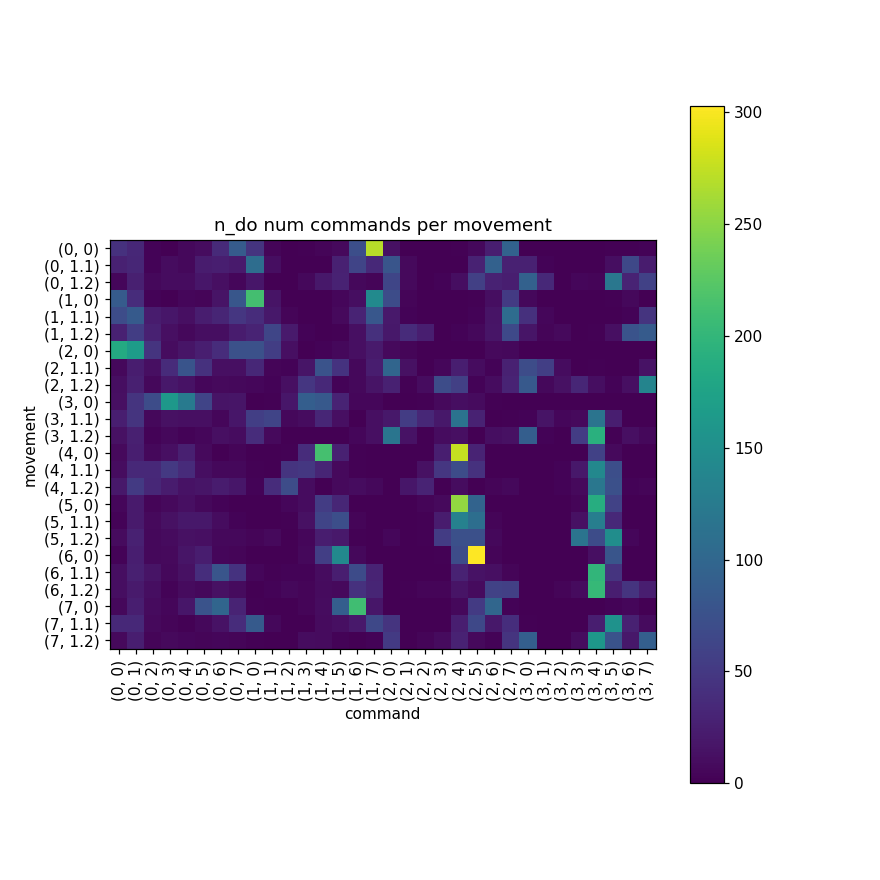

<IPython.core.display.Javascript object>


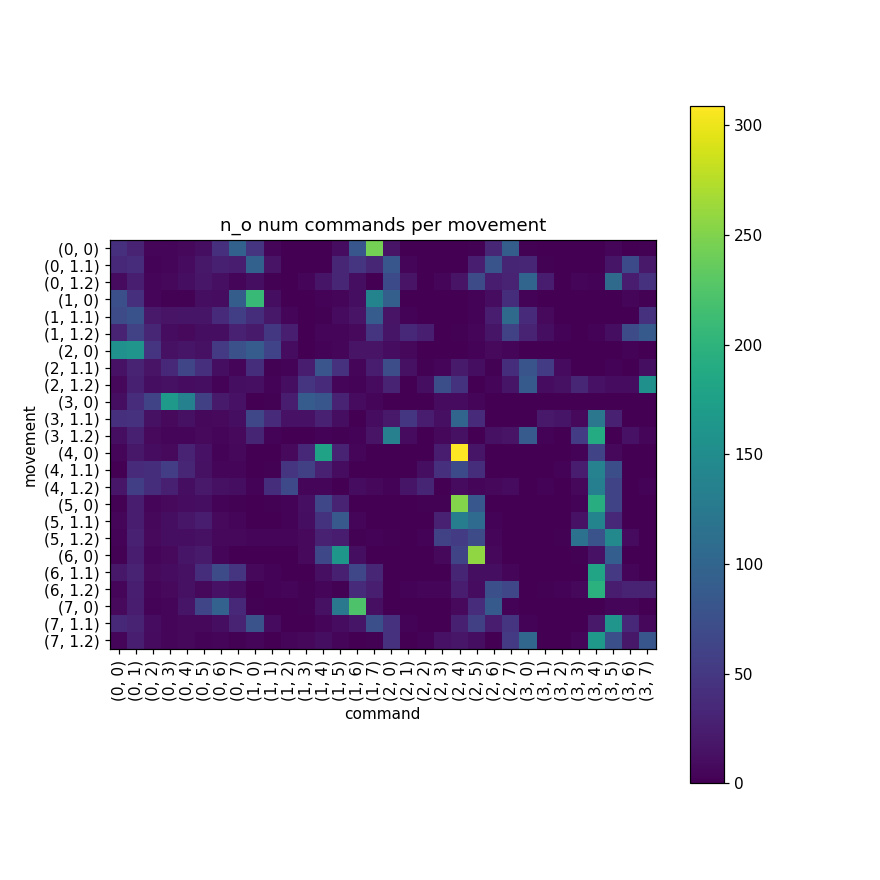

<IPython.core.display.Javascript object>


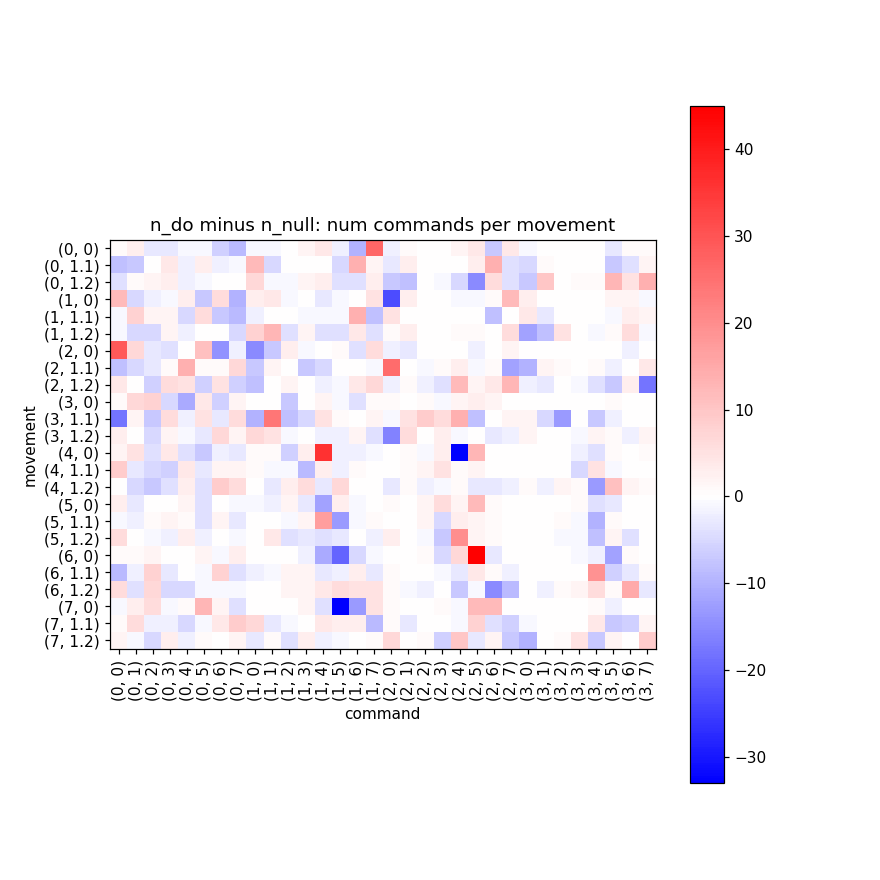

In [60]:
# plt.figure(figsize=(16,8))
for i,model in enumerate(model_list):
#     plt.subplot(2,1,i+1)
    plt.figure(figsize=(8,8))
    plt.imshow(model_cm_dist[model], cmap='viridis')
    plt.xticks(range(num_c),c_list,rotation=90)
    plt.yticks(range(num_move),m_list,rotation=0)
    plt.xlabel('command')
    plt.ylabel('movement')
    
    plt.title(model + ' num commands per movement')
    plt.colorbar()

#DIFF: 
dist_diff = model_cm_dist['n_do'] - model_cm_dist['n_o']
v_mid = 0
v_min = dist_diff.min()
v_max = dist_diff.max()
plt.figure(figsize=(8,8))
plt.imshow(dist_diff, cmap='bwr', norm=MidpointNormalize(midpoint=v_mid,vmin=v_min, vmax=v_max))    
plt.xticks(range(num_c),c_list,rotation=90)
plt.yticks(range(num_move),m_list,rotation=0)
plt.xlabel('command')
plt.ylabel('movement')

plt.title('n_do minus n_null:' + ' num commands per movement')
plt.colorbar()

### Match command distribution

In [ ]:
# bmi_b.subsample_dataset_to_match_mean_target_dataset()
# INPUT: 
# match_var, d_ss, d_target, p_sig=0.05, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1
# OUTPUT:  
#success, kept_list, discard_list, df_match, ttest_r, mean_r

In [ ]:
list(df_lqr.columns)

In [ ]:
#xarray dims: ['v', 'observation']
#can you assign df to DataArray directly? 

#bmi_b.df_idx2da(df, idx, var)
#             index_i = list(df_lqr.loc[].index.values) 
#             xr.DataArray(np.array(df_i).T, coords={}, dims=['v', 'observation'])

In [62]:
#Collect the selection 
t_start = timeit.default_timer()
model_cm = {} #model,command,movement data
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df
model_list = ['n_do', 'n_o']
for model in model_list: #model
    sel_model = (df_lqr['model'] == model)
    for ic, c in enumerate(c_list): #command
        bm = c[0]
        ba = c[1]
        sel_ba = (df_lqr.loc[:,'u_v_angle_bin']==ba)
        sel_bm = (df_lqr.loc[:,'u_v_mag_bin']==bm) 
        sel_c = sel_model&sel_ba&sel_bm   
        model_cm[model,c,'sel'] = sel_c
        model_cm[model,c,'num_obs'] = sum(sel_c)
        for im, m in enumerate(m_list): #movement
            print(model, c, m)
            target = m[0]
            task = m[1]
            sel_m = (df_lqr.loc[:,'target']==target)&(df_lqr.loc[:,'task_rot']==task)
            sel_cm = sel_c&sel_m
            model_cm[model,c,m,'sel'] = sel_cm
            model_cm[model,c,m,'num_obs'] = sum(sel_cm)
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (0, 0), (0, 0))
('n_do', (0, 0), (0, 1.1))
('n_do', (0, 0), (0, 1.2))
('n_do', (0, 0), (1, 0))
('n_do', (0, 0), (1, 1.1))
('n_do', (0, 0), (1, 1.2))
('n_do', (0, 0), (2, 0))
('n_do', (0, 0), (2, 1.1))
('n_do', (0, 0), (2, 1.2))
('n_do', (0, 0), (3, 0))
('n_do', (0, 0), (3, 1.1))
('n_do', (0, 0), (3, 1.2))
('n_do', (0, 0), (4, 0))
('n_do', (0, 0), (4, 1.1))
('n_do', (0, 0), (4, 1.2))
('n_do', (0, 0), (5, 0))
('n_do', (0, 0), (5, 1.1))
('n_do', (0, 0), (5, 1.2))
('n_do', (0, 0), (6, 0))
('n_do', (0, 0), (6, 1.1))
('n_do', (0, 0), (6, 1.2))
('n_do', (0, 0), (7, 0))
('n_do', (0, 0), (7, 1.1))
('n_do', (0, 0), (7, 1.2))
('n_do', (0, 1), (0, 0))
('n_do', (0, 1), (0, 1.1))
('n_do', (0, 1), (0, 1.2))
('n_do', (0, 1), (1, 0))
('n_do', (0, 1), (1, 1.1))
('n_do', (0, 1), (1, 1.2))
('n_do', (0, 1), (2, 0))
('n_do', (0, 1), (2, 1.1))
('n_do', (0, 1), (2, 1.2))
('n_do', (0, 1), (3, 0))
('n_do', (0, 1), (3, 1.1))
('n_do', (0, 1), (3, 1.2))
('n_do', (0, 1), (4, 0))
('n_do', (0, 1), (4, 1.1))


('n_do', (1, 5), (6, 0))
('n_do', (1, 5), (6, 1.1))
('n_do', (1, 5), (6, 1.2))
('n_do', (1, 5), (7, 0))
('n_do', (1, 5), (7, 1.1))
('n_do', (1, 5), (7, 1.2))
('n_do', (1, 6), (0, 0))
('n_do', (1, 6), (0, 1.1))
('n_do', (1, 6), (0, 1.2))
('n_do', (1, 6), (1, 0))
('n_do', (1, 6), (1, 1.1))
('n_do', (1, 6), (1, 1.2))
('n_do', (1, 6), (2, 0))
('n_do', (1, 6), (2, 1.1))
('n_do', (1, 6), (2, 1.2))
('n_do', (1, 6), (3, 0))
('n_do', (1, 6), (3, 1.1))
('n_do', (1, 6), (3, 1.2))
('n_do', (1, 6), (4, 0))
('n_do', (1, 6), (4, 1.1))
('n_do', (1, 6), (4, 1.2))
('n_do', (1, 6), (5, 0))
('n_do', (1, 6), (5, 1.1))
('n_do', (1, 6), (5, 1.2))
('n_do', (1, 6), (6, 0))
('n_do', (1, 6), (6, 1.1))
('n_do', (1, 6), (6, 1.2))
('n_do', (1, 6), (7, 0))
('n_do', (1, 6), (7, 1.1))
('n_do', (1, 6), (7, 1.2))
('n_do', (1, 7), (0, 0))
('n_do', (1, 7), (0, 1.1))
('n_do', (1, 7), (0, 1.2))
('n_do', (1, 7), (1, 0))
('n_do', (1, 7), (1, 1.1))
('n_do', (1, 7), (1, 1.2))
('n_do', (1, 7), (2, 0))
('n_do', (1, 7), (2, 1.1))


('n_do', (3, 3), (6, 0))
('n_do', (3, 3), (6, 1.1))
('n_do', (3, 3), (6, 1.2))
('n_do', (3, 3), (7, 0))
('n_do', (3, 3), (7, 1.1))
('n_do', (3, 3), (7, 1.2))
('n_do', (3, 4), (0, 0))
('n_do', (3, 4), (0, 1.1))
('n_do', (3, 4), (0, 1.2))
('n_do', (3, 4), (1, 0))
('n_do', (3, 4), (1, 1.1))
('n_do', (3, 4), (1, 1.2))
('n_do', (3, 4), (2, 0))
('n_do', (3, 4), (2, 1.1))
('n_do', (3, 4), (2, 1.2))
('n_do', (3, 4), (3, 0))
('n_do', (3, 4), (3, 1.1))
('n_do', (3, 4), (3, 1.2))
('n_do', (3, 4), (4, 0))
('n_do', (3, 4), (4, 1.1))
('n_do', (3, 4), (4, 1.2))
('n_do', (3, 4), (5, 0))
('n_do', (3, 4), (5, 1.1))
('n_do', (3, 4), (5, 1.2))
('n_do', (3, 4), (6, 0))
('n_do', (3, 4), (6, 1.1))
('n_do', (3, 4), (6, 1.2))
('n_do', (3, 4), (7, 0))
('n_do', (3, 4), (7, 1.1))
('n_do', (3, 4), (7, 1.2))
('n_do', (3, 5), (0, 0))
('n_do', (3, 5), (0, 1.1))
('n_do', (3, 5), (0, 1.2))
('n_do', (3, 5), (1, 0))
('n_do', (3, 5), (1, 1.1))
('n_do', (3, 5), (1, 1.2))
('n_do', (3, 5), (2, 0))
('n_do', (3, 5), (2, 1.1))


('n_o', (1, 1), (3, 1.1))
('n_o', (1, 1), (3, 1.2))
('n_o', (1, 1), (4, 0))
('n_o', (1, 1), (4, 1.1))
('n_o', (1, 1), (4, 1.2))
('n_o', (1, 1), (5, 0))
('n_o', (1, 1), (5, 1.1))
('n_o', (1, 1), (5, 1.2))
('n_o', (1, 1), (6, 0))
('n_o', (1, 1), (6, 1.1))
('n_o', (1, 1), (6, 1.2))
('n_o', (1, 1), (7, 0))
('n_o', (1, 1), (7, 1.1))
('n_o', (1, 1), (7, 1.2))
('n_o', (1, 2), (0, 0))
('n_o', (1, 2), (0, 1.1))
('n_o', (1, 2), (0, 1.2))
('n_o', (1, 2), (1, 0))
('n_o', (1, 2), (1, 1.1))
('n_o', (1, 2), (1, 1.2))
('n_o', (1, 2), (2, 0))
('n_o', (1, 2), (2, 1.1))
('n_o', (1, 2), (2, 1.2))
('n_o', (1, 2), (3, 0))
('n_o', (1, 2), (3, 1.1))
('n_o', (1, 2), (3, 1.2))
('n_o', (1, 2), (4, 0))
('n_o', (1, 2), (4, 1.1))
('n_o', (1, 2), (4, 1.2))
('n_o', (1, 2), (5, 0))
('n_o', (1, 2), (5, 1.1))
('n_o', (1, 2), (5, 1.2))
('n_o', (1, 2), (6, 0))
('n_o', (1, 2), (6, 1.1))
('n_o', (1, 2), (6, 1.2))
('n_o', (1, 2), (7, 0))
('n_o', (1, 2), (7, 1.1))
('n_o', (1, 2), (7, 1.2))
('n_o', (1, 3), (0, 0))
('n_o', (1, 

('n_o', (2, 7), (1, 0))
('n_o', (2, 7), (1, 1.1))
('n_o', (2, 7), (1, 1.2))
('n_o', (2, 7), (2, 0))
('n_o', (2, 7), (2, 1.1))
('n_o', (2, 7), (2, 1.2))
('n_o', (2, 7), (3, 0))
('n_o', (2, 7), (3, 1.1))
('n_o', (2, 7), (3, 1.2))
('n_o', (2, 7), (4, 0))
('n_o', (2, 7), (4, 1.1))
('n_o', (2, 7), (4, 1.2))
('n_o', (2, 7), (5, 0))
('n_o', (2, 7), (5, 1.1))
('n_o', (2, 7), (5, 1.2))
('n_o', (2, 7), (6, 0))
('n_o', (2, 7), (6, 1.1))
('n_o', (2, 7), (6, 1.2))
('n_o', (2, 7), (7, 0))
('n_o', (2, 7), (7, 1.1))
('n_o', (2, 7), (7, 1.2))
('n_o', (3, 0), (0, 0))
('n_o', (3, 0), (0, 1.1))
('n_o', (3, 0), (0, 1.2))
('n_o', (3, 0), (1, 0))
('n_o', (3, 0), (1, 1.1))
('n_o', (3, 0), (1, 1.2))
('n_o', (3, 0), (2, 0))
('n_o', (3, 0), (2, 1.1))
('n_o', (3, 0), (2, 1.2))
('n_o', (3, 0), (3, 0))
('n_o', (3, 0), (3, 1.1))
('n_o', (3, 0), (3, 1.2))
('n_o', (3, 0), (4, 0))
('n_o', (3, 0), (4, 1.1))
('n_o', (3, 0), (4, 1.2))
('n_o', (3, 0), (5, 0))
('n_o', (3, 0), (5, 1.1))
('n_o', (3, 0), (5, 1.2))
('n_o', (3, 

### For each command, identify the subset of the pool command distribution which matches command mean

In [68]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [70]:
c_list_a = [c_list[0]]

In [71]:
c_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7)]

In [72]:
t_start = timeit.default_timer()
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df
model_list = ['n_do', 'n_o']
var = ['u_vx', 'u_vy']
match_var = var
c_list_a = [(3, 0)]
for model in model_list: #model
    for ic, c in enumerate(c_list_a): #command    
        sel_c = model_cm[model,c,'sel']
        c_idx = df_lqr[sel_c].index.values
        c_da = bmi_b.df_idx2da(df_lqr,c_idx,var)
        
        for im, m in enumerate(m_list): #movement
            #data array of var of interest
            print(model, c, m)
            sel_cm = model_cm[model,c,m,'sel']
            cm_idx = df_lqr[sel_cm].index.values
            cm_da = bmi_b.df_idx2da(df_lqr,cm_idx,var)
            
            success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                    bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=c_da, d_target=cm_da, p_sig=0.05, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
            model_cm[model,c,m,'pool_match_idx'] = kept_list[0]
            model_cm[model,c,m,'pool_match_success'] = success
            model_cm[model,c,m,'pool_match_discard'] = discard_list[0]
            model_cm[model,c,m,'pool_match_ttest'] = ttest_r
            model_cm[model,c,m,'pool_match_mean'] = mean_r                    
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)#/(60.0*60.0))    

('n_do', (3, 0), (0, 0))
0.95
matched!
('n_do', (3, 0), (0, 1.1))
0.95
matched!
('n_do', (3, 0), (0, 1.2))
0.95
505
0.9
478
0.85
452
0.8
425
0.75
399
0.7
372
0.65
345
0.6
319
0.55
292
0.5
266
0.45
matched!
('n_do', (3, 0), (1, 0))
0.95
matched!
('n_do', (3, 0), (1, 1.1))
0.95
505
0.9
478
0.85
452
0.8
425
0.75
399
0.7
372
0.65
345
0.6
319
0.55
292
0.5
266
0.45
239
0.4
212
0.35
186
0.3
159
0.25
133
0.2
matched!
('n_do', (3, 0), (1, 1.2))
0.95
505
0.9
478
0.85
452
0.8
425
0.75
399
0.7
372
0.65
345
0.6
319
0.55
292
0.5
266
0.45
239
0.4
212
0.35
186
0.3
159
0.25
matched!
('n_do', (3, 0), (2, 0))
0.95
matched!
('n_do', (3, 0), (2, 1.1))
0.95
505
0.9
matched!
('n_do', (3, 0), (2, 1.2))
0.95
505
0.9
478
0.85
452
0.8
425
0.75
399
0.7
372
0.65
345
0.6
319
0.55
292
0.5
266
0.45
239
0.4
212
0.35
186
0.3
159
0.25
matched!
('n_do', (3, 0), (3, 0))
0.95
matched!
('n_do', (3, 0), (3, 1.1))
0.95
matched!
('n_do', (3, 0), (3, 1.2))
0.95
505
0.9
478
0.85
452
0.8
425
0.75
matched!
('n_do', (3, 0), (4, 0))

In [ ]:
#matching takes ~15 min
914/60.0

### Shuffle movement+time label of each command observation, to serve as a control

In [65]:
model_cm.keys()

[('n_o', (3, 6), (7, 1.2), 'sel'),
 ('n_do', (1, 6), (0, 1.2), 'num_obs'),
 ('n_o', (2, 0), (3, 1.2), 'sel'),
 ('n_do', (3, 6), (0, 1.1), 'sel'),
 ('n_do', (1, 4), (2, 0), 'num_obs'),
 ('n_do', (1, 2), (6, 1.2), 'num_obs'),
 ('n_o', (2, 7), 'sel'),
 ('n_o', (0, 7), (4, 1.2), 'sel'),
 ('n_o', (3, 2), (5, 1.2), 'sel'),
 ('n_do', (1, 0), (7, 1.1), 'sel'),
 ('n_do', (0, 1), (4, 1.1), 'sel'),
 ('n_o', (2, 2), (0, 1.1), 'num_obs'),
 ('n_o', (3, 3), (3, 1.2), 'num_obs'),
 ('n_do', (0, 2), (4, 1.1), 'pool_match_ttest'),
 ('n_do', (0, 6), (3, 1.1), 'pool_match_idx'),
 ('n_do', (2, 5), (4, 1.2), 'num_obs'),
 ('n_do', (0, 1), (4, 0), 'shuffle_mat'),
 ('n_do', (0, 1), (7, 0), 'shuffle_mat'),
 ('n_o', (0, 3), (1, 0), 'sel'),
 ('n_do', (1, 7), (1, 1.2), 'num_obs'),
 ('n_do', (0, 4), (0, 0), 'pool_match_discard'),
 ('n_o', (2, 5), (6, 0), 'num_obs'),
 ('n_o', (2, 4), (2, 1.1), 'num_obs'),
 ('n_do', (0, 0), (6, 1.1), 'sel'),
 ('n_do', (2, 5), (5, 1.2), 'sel'),
 ('n_do', (0, 2), (3, 1.1), 'pool_match_d

In [66]:
model_list

['n_do', 'n_o']

In [73]:
#make a shuffle mat for each command.
#shuffle mat contains the idxs chosen for each shuffle 
#For each movement, pick K samples at random from the 'movement-pooled'
t_start = timeit.default_timer()
num_shuffle = 10
for model in model_list:
    for c in c_list_a: #c_list:
        for m in m_list:
            c_idxs = model_cm[model,c,m,'pool_match_idx']
            num_obs = model_cm[model,c,m,'num_obs']
            shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
            
            if len(c_idxs)<num_obs:
                for s in range(num_shuffle):
                    shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
            else:
                for s in range(num_shuffle):
                    shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
            #ASSIGN:
            model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
t_elapsed = timeit.default_timer()-t_start       
print(t_elapsed)

0.0577911


In [ ]:
1072/60.0

### Check differences based on the matched idxs: 

In [77]:
move_list

[(0, 0),
 (0, 1.1),
 (0, 1.2),
 (1, 0),
 (1, 1.1),
 (1, 1.2),
 (2, 0),
 (2, 1.1),
 (2, 1.2),
 (3, 0),
 (3, 1.1),
 (3, 1.2),
 (4, 0),
 (4, 1.1),
 (4, 1.2),
 (5, 0),
 (5, 1.1),
 (5, 1.2),
 (6, 0),
 (6, 1.1),
 (6, 1.2),
 (7, 0),
 (7, 1.1),
 (7, 1.2)]

In [78]:
model_cm[model,(3,0),(0,0),'n_diff_s_norm']

KeyError: ('n_o', (3, 0), (0, 1.1), 'n_diff_s_norm')

In [ ]:
model_cm[model,(0,0),(0,0),'n_diff_s_norm_mean']

In [ ]:
df_lqr.shape

In [80]:
n_df_lqr = np.array(df_lqr[n_list])
n_df_lqr.shape

(74880L, 20L)

In [81]:
t_start = timeit.default_timer()

shuffle_bool = True

mean_var = copy.copy(n_list)
for model in model_list: #model
    for ic, c in enumerate(c_list_a): #enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement

            if model_cm[model,c,m,'pool_match_success']:    
                print(model,c,m)
                c_idxs = model_cm[model,c,m,'pool_match_idx']#use these idxs for average
#                 mu_c = df_lqr.loc[c_idxs, mean_var].mean()
                mu_c = n_df_lqr[c_idxs, :].mean(axis=0) 
        
                #MOVE:
                cm_sel = model_cm[model,c,m,'sel']
                cm_idxs = cm_sel[cm_sel].index.values
#                 mu_cm = df_lqr.loc[cm_idxs, mean_var].mean()       
                mu_cm = n_df_lqr[cm_idxs, :].mean(axis=0) 

                if shuffle_bool: 
                    #SHUFFLE:
                    nan_mat = np.ones((len(mean_var), num_shuffle))*np.nan
                    s_mean = xr.DataArray(nan_mat, 
                                      coords={'v':mean_var,'shuffle':range(num_shuffle)},
                                      dims=['v','shuffle'])
                    for s in range(num_shuffle):
                        s_idxs = model_cm[model,c,m,'shuffle_mat'][:,s].astype(int)
#                         mu_s = df_lqr.loc[s_idxs, mean_var].mean()
                        mu_s = n_df_lqr[s_idxs, :].mean(axis=0)
                        s_mean.loc[:,s] = mu_s

                #DIFFERENCE: 

                #ASSIGN:
#                 model_cm[model,c,m,'mat_df'] = df_lqr.loc[cm_idxs, mean_var]
                model_cm[model,c,m,'n_c'] = mu_c
                model_cm[model,c,m,'n_cm'] = mu_cm
  
                diff_i = mu_c-mu_cm   
                diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                model_cm[model,c,m,'n_diff_true'] = diff_i             
                model_cm[model,c,m,'n_diff_norm_true'] = np.linalg.norm(diff_i)
                model_cm[model,c,m,'n_diff_norm_potent'] = np.linalg.norm(diff_potent_i)
                model_cm[model,c,m,'n_diff_norm_null'] = np.linalg.norm(diff_null_i)

                if shuffle_bool: 
                    model_cm[model,c,m,'n_s'] = s_mean              
                    n_c_rep = np.array(mu_c)[...,None]
                    model_cm[model,c,m,'n_diff_s'] = n_c_rep-s_mean
                    model_cm[model,c,m,'n_diff_s_norm'] = np.linalg.norm(model_cm[model,c,m,'n_diff_s'], axis=0)
                    model_cm[model,c,m,'n_diff_s_norm_mean'] = model_cm[model,c,m,'n_diff_s_norm'].mean()

t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)

('n_do', (3, 0), (0, 0))
('n_do', (3, 0), (0, 1.1))
('n_do', (3, 0), (0, 1.2))
('n_do', (3, 0), (1, 0))
('n_do', (3, 0), (1, 1.1))
('n_do', (3, 0), (1, 1.2))
('n_do', (3, 0), (2, 0))


c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice.


('n_do', (3, 0), (2, 1.1))
('n_do', (3, 0), (2, 1.2))
('n_do', (3, 0), (3, 0))
('n_do', (3, 0), (3, 1.1))
('n_do', (3, 0), (3, 1.2))
('n_do', (3, 0), (4, 0))
('n_do', (3, 0), (4, 1.1))
('n_do', (3, 0), (4, 1.2))
('n_do', (3, 0), (5, 0))
('n_do', (3, 0), (5, 1.1))
('n_do', (3, 0), (5, 1.2))
('n_do', (3, 0), (6, 0))
('n_do', (3, 0), (6, 1.1))
('n_do', (3, 0), (6, 1.2))
('n_do', (3, 0), (7, 0))
('n_do', (3, 0), (7, 1.1))
('n_do', (3, 0), (7, 1.2))
('n_o', (3, 0), (0, 0))
('n_o', (3, 0), (0, 1.1))
('n_o', (3, 0), (0, 1.2))
('n_o', (3, 0), (1, 0))
('n_o', (3, 0), (1, 1.1))
('n_o', (3, 0), (1, 1.2))
('n_o', (3, 0), (2, 0))
('n_o', (3, 0), (2, 1.1))
('n_o', (3, 0), (2, 1.2))
('n_o', (3, 0), (3, 0))
('n_o', (3, 0), (3, 1.1))
('n_o', (3, 0), (3, 1.2))
('n_o', (3, 0), (4, 0))
('n_o', (3, 0), (4, 1.1))
('n_o', (3, 0), (4, 1.2))
('n_o', (3, 0), (5, 0))
('n_o', (3, 0), (5, 1.1))
('n_o', (3, 0), (5, 1.2))
('n_o', (3, 0), (6, 0))
('n_o', (3, 0), (6, 1.1))
('n_o', (3, 0), (6, 1.2))
('n_o', (3, 0), (7,

In [ ]:
3284.152986/60

# WE ARE HERE WAITING ABOVE CELL TO FINISH!

In [ ]:
model_cm['n_do',(0,0),(0,1.2),'n_diff_norm_true']

In [ ]:
model_cm['n_do',(0,0),(0,1.2),'n_diff_s_norm_mean']

In [ ]:
model_cm['n_null',(0,0),(0,1.2),'n_diff_norm_true']

In [ ]:
model_cm['n_null',(0,0),(0,1.2),'n_diff_s_norm_mean']

In [85]:
#loop over all conditions, collect a list of differences:
# model_diff = {'n_do':[], 'n_null':[]}
shuffle_bool = True
min_obs = 15
model_diff = {}
for model in ['n_do', 'n_o']: #model_list: #model
    model_diff[model] = {'total':[], 'potent':[],'null':[], 'shuffle':[]}
    for ic, c in enumerate(c_list_a): #enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            if model_cm[model,c,m,'pool_match_success']:  
                #project the diff
                
                diff_i = model_cm[model,c,m,'n_diff_true']
                
                if model_cm[model,c,m,'num_obs'] > min_obs:
                    if not np.isnan(diff_i).any():
                        diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                        norm_potent_i = np.linalg.norm(diff_potent_i)
                        norm_null_i = np.linalg.norm(diff_null_i)

                        model_diff[model]['total'].append(model_cm[model,c,m,'n_diff_norm_true'])
                        model_diff[model]['potent'].append(norm_potent_i)
                        model_diff[model]['null'].append(norm_null_i)
                        
                        if shuffle_bool: 
                            model_diff[model]['shuffle'].append(model_cm[model,c,m,'n_diff_s_norm_mean'])
                            
                

<IPython.core.display.Javascript object>


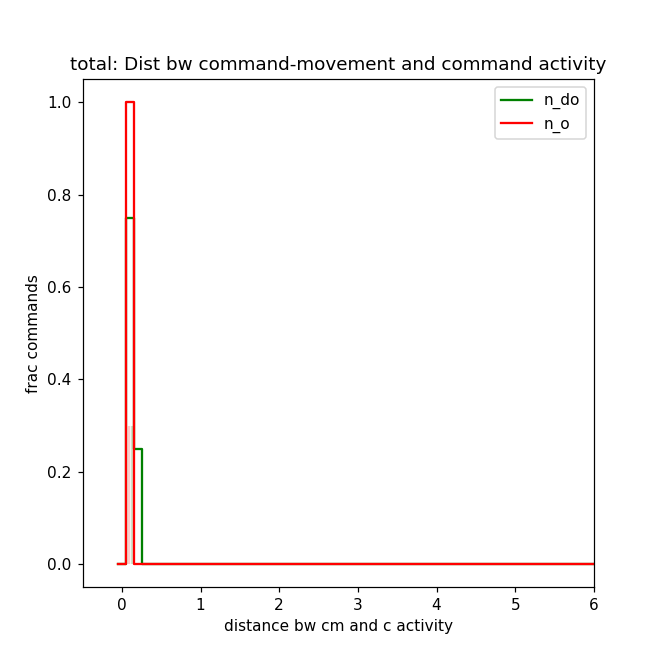

151
(304L,)
('n_do', 0.13494679768858073)
151
(304L,)
('n_o', 0.09677855411169389)


<IPython.core.display.Javascript object>


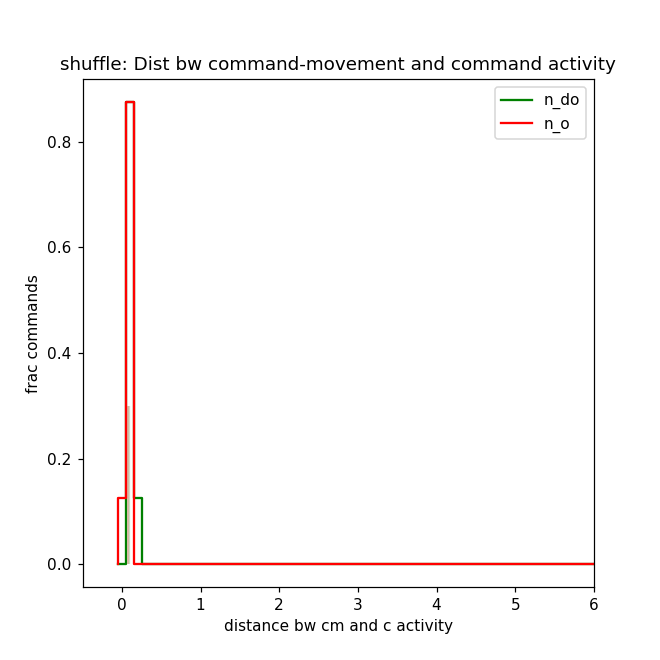

151
(304L,)
('n_do', 0.08977082865453687)
151
(304L,)
('n_o', 0.0761090410642373)


In [86]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=15
num_bins = (vmax-vmin)*10+1
if shuffle_bool:
    for diff_type in ['total', 'shuffle']:


        cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
        bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
        cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
        bin_dic = {0:cm_diff_bins_e}

        cm_diff_binned = {'n_do':[], 'n_o':[]}

        model_list = ['n_do', 'n_o']
        for model in model_list:
            d = np.array(model_diff[model][diff_type]).reshape((-1,1))
            bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
            cm_diff_binned[model] = hist_result


        model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
        cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

        plt.figure(figsize=(6,6))
        for model,d in cm_diff_binned.items():
            d_plot = d/np.sum(d)
        #     d_plot = np.cumsum(d_plot)
            bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

            d_mean = np.mean(model_diff[model][diff_type])
            plt.vlines(d_mean, 0, 0.3, color=model_color[model],alpha=0.2)
            print(model, d_mean)
        plt.xlim((-0.5,6))    
        plt.legend()    
        plt.xlabel('distance bw cm and c activity')
        plt.ylabel('frac commands')
        plt.title(diff_type + ': Dist bw command-movement and command activity')


In [ ]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=15
num_bins = (vmax-vmin)*10+1
for diff_type in ['total', 'null', 'potent']:

    
    cm_diff_bins_c = np.linspace(vmin,vmax,num_bins)
    bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
    cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
    bin_dic = {0:cm_diff_bins_e}

    cm_diff_binned = {'n_do':[], 'n_null':[]}

    model_list = ['n_do', 'n_null']
    for model in model_list:
        d = np.array(model_diff[model][diff_type]).reshape((-1,1))
        bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
        cm_diff_binned[model] = hist_result


    model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
    cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

    plt.figure(figsize=(6,6))
    for model,d in cm_diff_binned.items():
        d_plot = d/np.sum(d)
    #     d_plot = np.cumsum(d_plot)
        bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

        d_mean = np.mean(model_diff[model][diff_type])
        plt.vlines(d_mean, 0, 0.3, color=model_color[model],alpha=0.2)
        print(model, d_mean)
    plt.xlim((-0.5,6))    
    plt.legend()    
    plt.xlabel('distance bw cm and c activity')
    plt.ylabel('frac commands')
    plt.title(diff_type + ': Dist bw command-movement and command activity')


In [ ]:
#loop over all conditions, difference between both models:
model_m_diff = []
for ic, c in enumerate(c_list): #command    
    for im, m in enumerate(m_list): #movement
        if model_cm['n_do',c,m,'pool_match_success'] and model_cm['n_null',c,m,'pool_match_success']:  
            print(model_cm['n_do',c,m,'num_obs'], len(model_cm['n_do',c,m,'pool_match_idx']), model_cm['n_null',c,m,'num_obs'], len(model_cm['n_null',c,m,'pool_match_idx']))
            
            diff_i = model_cm['n_do',c,m,'n_diff_norm_true']-model_cm['n_null',c,m,'n_diff_norm_true']
            if not np.isnan(diff_i):
                model_m_diff.append(diff_i)

In [ ]:
np.mean(model_m_diff)

In [ ]:
plt.figure()
_=plt.hist(model_m_diff, bins=np.arange(-1.5,4.5,.25))
plt.vlines(np.mean(model_m_diff), 0, 150, color='r')
plt.vlines(0, 0, 150, color='k')

In [ ]:
save_path

In [ ]:
#Save analysis results: 
r = {}
r['df_mean'] = df_mean
r['df_diff'] = df_diff
r['model_cm'] = model_cm
r['min_obs'] = min_obs
r['model_diff'] = model_diff
r['model_m_diff'] = model_m_diff


r['cm_diff_binned'] = cm_diff_binned
r['cm_diff_bins_e_flat'] = cm_diff_bins_e_flat

r['mag_bin'] = mag_bin
r['mag_bin_edges'] = mag_bin_edges
r['mag_bin_c'] = mag_bin_c
r['angle_bin_c'] = angle_bin_c
r['angle_bin'] = angle_bin
r['angle_bin_edges'] = angle_bin_edges
r['angle_center_for_binning'] = angle_center_for_binning
r['num_mag_bins_analyze'] = num_mag_bins_analyze

### Save noiseless lqr data: 
save_dir_backup = r'D:\DATA\bmi_co_obs_backup'
# save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'analysis_lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr_1000_shuffle.pkl')
save_path = os.path.join(r'D:\DATA\bmi_co_obs_backup', 'analysis_lqr_noise_1000trials_noise_diag_from_noiseless_n_null_lqr_1000_shuffle.pkl')
with open(save_path, 'wb') as f: 
    data = pickle.dump(r, f, protocol=pickle.HIGHEST_PROTOCOL)
    
#AHHH, saving 

In [ ]:
save_dir

In [ ]:
#LOAD THIS DATA!
load_dir = r'D:\DATA\bmi_co_obs_backup'
save_path = os.path.join(load_dir, 'analysis_lqr_noise_20trials_noise_diag_from_noiseless_n_null_lqr_1000_shuffle.pkl')
with open(save_path, 'rb') as f: 
    r = pickle.load(f)
#Note the simulations were run with neural activity initialized to 0    
for (k,v) in r.items():
    exec(k+'=v')

### Check example command and movements

In [ ]:
#assign to df, sloppy coding variable names.
df = df_lqr

In [ ]:
#Identify movements + num_obs +sel for each command
#also save for each movement separately

bin_buffer = 5 #only count data after the first 5 samples and before the last 5 samples: 
min_obs = 15
cm_dic = {}
#Loop over command:
for model in model_list:
    for c in c_list: 
        bm = c[0]
        ba = c[1]

        cm_dic[model, c] = []
        cm_dic[model, c,'num_obs'] = []
        #Loop over movement: 
        for m in move_list:
            print(model, c, m)
            sel = \
            (df['model']==model) \
            &(df['target']==m[0]) \
            & (df['task_rot']==m[1]) \
            & (df['bin'] >= bin_buffer) \
            & (df['bin_end'] >= bin_buffer) \
            & (df['u_v_mag_bin'] == bm) \
            & (df['u_v_angle_bin'] == ba)
            num_obs = sum(sel)
    #             print(bm, ba, m, num_obs)
            #ASSIGN:
            cm_dic[model,c,m,'sel'] = sel
            cm_dic[model,c,m,'num_obs'] = num_obs
            if num_obs >= min_obs:
                cm_dic[model,c].append(m)
                cm_dic[model,c,'num_obs'].append(num_obs)
#Make the movement-pool sel: 
for model in model_list:
    for c in c_list:
        bm = c[0]
        ba = c[1]
        cm_dic[model, c, 'sel'] = np.zeros(df.shape[0]).astype('bool')
        for m in cm_dic[model,(bm,ba)]:
            cm_dic[model, c, 'sel'] = cm_dic[model, c, 'sel'] \
            | cm_dic[model, c,m,'sel']
    #movement-pool sel wil be useful as the global mean for command-activity.

In [ ]:
num_m = len(m_list)
m2idx = {}
idx2m = {}
m2label={}
label2m={}
for i,m in enumerate(m_list):
    m2idx[m]=i
    idx2m[i]=m
    
    label = 'm_'+str(i)
    m2label[m] = label
    label2m[label] = m
    

num_c = len(c_list)
c2idx = {}
idx2c = {}
c2label={}
label2c={}
for i,c in enumerate(c_list):
    c2idx[c]=i
    idx2c[i]=c
    
    label = 'c_'+str(i)
    c2label[c] = label
    label2c[label] = c    

In [ ]:
c_list

In [ ]:
cm_dic['n_do', c]

In [ ]:
cm_dic['n_null', c]

In [ ]:
not model_cm[model,c,m,'pool_match_success']

In [ ]:
m_list

In [ ]:
m_analyze

In [ ]:
c = (2,1)

#(2,1)
#To Try: 
#(3,2)
#(1,7)

l1 = set(cm_dic['n_do', c])
m_analyze = list(l1.intersection(cm_dic['n_null', c]))


for model in ['n_do', 'n_null']: 
    for m in m_analyze: 
        if not model_cm[model,c,m,'pool_match_success']:
            print(m)
#             m_analyze.remove(m)
            
# m_analyze

In [ ]:
### Example command: 
c = (2,1)

#(2,1)
#To Try: 
#(3,2)
#(1,7)

l1 = set(cm_dic['n_do', c])
m_analyze = list(l1.intersection(cm_dic['n_null', c]))

model_list = ['n_do','n_null']
m_remove = []
for model in model_list: 
    for m in m_analyze: 
        if not model_cm[model,c,m,'pool_match_success']:
            m_remove.append(m)
for m in m_remove: 
    if m in m_analyze:
        m_analyze.remove(m)

m_analyze

# for model in model_list: 
#     for m in m_analyze: 
#         print(m)
#         print(model_cm[model,c,m,'n_diff_norm_true'])

# for model in model_list:
#     m_analyze = cm_dic[model, c]
#     print(model, m_analyze)

In [ ]:
#Re-order: 
m_analyze = [(0, 1.1), (0, 1.2), (1, 0), (2, 1.1), (2, 1.2), (3, 1.1), (3, 1.2)]
m_analyze

In [ ]:
c = (2,1)
min_obs = 15
m_analyze = []
for m in m_list:
    analyze_bool = True
    for model in model_list:
        analyze_bool = analyze_bool and (model_cm[model, c, m, 'num_cm_match'] >= min_obs)
    if analyze_bool:
        m_analyze.append(m)
m_analyze


In [ ]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command

bin_buffer_start = 5+1
bin_buffer_stop = 5
sel_b = (df['bin']>=bin_buffer_start)&(df['bin_end']>=bin_buffer_stop)


psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_dic = {}
psth_list = []
psthc_list = []
for model in model_list: 
    psth_list = []
    psthc_list = []
    
#     m_analyze = cm_dic[model, c]
    print(model)
    for m in m_analyze: 
    #     idx = np.where(cm_dic[c,m,'sel'])[0]

        idx_sel = cm_dic[model, c,m,'sel']
        idx_sel_a = idx_sel & sel_b

        #---------------------------------------------------------------------------------------------------------------------
        idx_a = np.where(idx_sel_a)[0]#-1 #we need to delay the position by one lag for exptal analysis, not for lqr
        #---------------------------------------------------------------------------------------------------------------------

        print(m, idx_a)

        da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df.loc[:,psth_var], idx_a, win, psth_var)
        #center at lag0:
        psthc = psth-psth.loc[:,0]
        psth_list.append(psth)
        psthc_list.append(psthc)  
        
    psth_dic[model, 'psth_list'] = psth_list
    psth_dic[model, 'psthc_list'] = psthc_list
        

In [ ]:
m_analyze

In [ ]:
c

In [ ]:
#PLOT the position PSTH

save_bool = False
for model in model_list:
    fig_name = model+'_command_locked_position_psth'
    psthc_list = psth_dic[model, 'psthc_list']
#     m_analyze = cm_dic[model, c]
    
    mag_bin = c[0]
    angle_bin = c[1]
    sc = 0.5

    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc

    # task_alpha = [1, 0.5]
    task_alpha_dic = {0:1, 1.1:0.5, 1.2:0.25}   #[1, 0.5, 0.25]
    plt.figure(figsize=(10,10))
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
    
        
    
    m_model = cm_dic[model, c]
    
    for i,psthc in enumerate(psthc_list):
        m = m_analyze[i]
#         m = m_model[i]
#         if m in m_analyze:
        

        task = m[1] #int(round(m[1]))
        target = int(m[0])
    #     plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
    #     plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
    #     plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  

        plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '-', alpha=task_alpha_dic[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
#         plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
#         plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')      


#     plt.xlim([-2.5, 2.5])
#     plt.ylim([-2.5, 2.5])
#     plt.axis('equal')
    plt.legend()
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
m_analyze

In [ ]:
c

In [ ]:
save_bool = False
figsize=(4,4)

center_bool = False

for model in model_list: 
    fig_name = model+'_neural_command_diff' 
#     m_analyze = cm_dic[model, c]

    d_plt = []
    s_list = []
    for i,m in enumerate(m_analyze):    
        d = model_cm[model,c,m,'n_diff_norm_true']
        
        
        if center_bool:
            d_diff = d-s
        else:
            d_diff = d
        d_plt.append(d_diff)
        
        print(m, model_cm[model,c,m,'num_obs'])
    #     plt.plot(i, model_cm[model,c,m,'n_diff_norm_true']        
            
    fig,ax=plt.subplots(figsize=figsize)    
    for i,m in enumerate(m_analyze):
#         task = int(round(m[1]))
        task = m[1]
        target = int(m[0])    
        plt.plot(i+1, d_plt[i], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target), zorder=1000)

    x_plt = np.arange(len(d_plt))+1
    # # plt.scatter(x_plt, d_plt, color='r', label='data mean')

    plt.xticks(x_plt, m_analyze)
    plt.xlabel('movement')
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
    plt.ylabel(ylabel_str)
    plt.title(model + ' ' + str(c))
    
    plt.ylim([-0.2, 1.2])        
    # plt.legend()


    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
save_dir

In [ ]:
num_neurons

In [ ]:
.014*44

In [ ]:
fig_name

In [ ]:
save_bool = False
figsize=(3,6)

center_bool = True
shuffle_bool = True

norm_by_neurons = True
if norm_by_neurons:
    normalizer = num_neurons
else:
    normalizer = 1

for model in model_list: 
    fig_name = model+'_neural_command_diff'
    if norm_by_neurons:
        fig_name += '_scaled'
#     m_analyze = cm_dic[model, c]

    d_plt = []
    s_list = []
    for i,m in enumerate(m_analyze):    
        d = model_cm[model,c,m,'n_diff_norm_true']
        
        

        
        print(m, model_cm[model,c,m,'num_obs'])
    #     plt.plot(i, model_cm[model,c,m,'n_diff_norm_true']        
        
        if shuffle_bool:
            s = model_cm[model,c,m,'n_diff_s_norm_mean']
            if center_bool:
                s_data=(model_cm[model,c,m,'n_diff_s_norm']-s)/normalizer
                s_list.append(s_data)
            else: 
                s_data = model_cm[model,c,m,'n_diff_s_norm']/normalizer
                s_list.append(s_data)
                
        if center_bool:
            d_diff = d-s
        else:
            d_diff = d
        d_plt.append(d_diff/normalizer)
        
                
    if shuffle_bool:
        medianprops=dict(linewidth=0)
        meanprops=dict(linestyle='-',linewidth=3,color='k')
    #     whis=[2.5,97.5]
        whis=[5,95]
        fig,ax=plt.subplots(figsize=figsize)
        _=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True
    else:
        fig,ax=plt.subplots(figsize=figsize)
            
    for i,m in enumerate(m_analyze):
#         task = int(round(m[1]))
        task = m[1]
        target = int(m[0])    
        plt.plot(i+1, d_plt[i], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target), zorder=1000)

    x_plt = np.arange(len(d_plt))+1
    # # plt.scatter(x_plt, d_plt, color='r', label='data mean')

    plt.xticks(x_plt, m_analyze)
    plt.xlabel('movement')
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
    plt.ylabel(ylabel_str)
    plt.title(model + ' ' + str(c))
    if center_bool:
        if norm_by_neurons:
            plt.ylim([-0.005, 0.0150])
        else:
            plt.ylim([-0.2, 0.7])
    # plt.legend()


    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
 model_cm[model,c,m,'pool_match_success']

In [ ]:
m_analyze

### Visualize activity in PC space: 

In [ ]:
#Data matrix

command_match = False
model_pc = {}
for model in model_list:
    d = []
    for m in m_analyze: 
#         di = np.dot(P_null, model_cm[model,c,m,'n_cm']-model_cm[model,c,m,'n_c'])
        if command_match: 
            di = model_cm[model,c,m,'n_cm']-model_cm[model,c,m,'n_c']
        else: 
            di = model_cm[model,c,m,'n_cm']
        d.append(np.array(di).reshape((-1,1)))  
    model_pc[model, 'data_mat'] = np.concatenate(d, axis=1)
    model_pc[model, 'mean'] = np.mean(model_pc[model, 'data_mat'], axis=1)
    model_pc[model, 'data_mat_c'] = model_pc[model, 'data_mat'] - model_pc[model, 'mean'].reshape((-1,1))
    u,s,vh = np.linalg.svd(model_pc[model, 'data_mat_c'])  
    model_pc[model, 'pc'] = u
    

In [ ]:
# #Projection into decoder null space
# Kn2v = Kn[2:4,:]
# u,s,vh = np.linalg.svd(Kn2v)
# vh_trunc = vh[:2,:]
# P = np.dot(vh_trunc.T,vh_trunc)
# P_null = np.eye(num_neurons)-P

In [ ]:
#TODO project into PCA space: 

#For each model:
#solve for the pc space
#project the average for each condition
#draw the shuffle

for model in model_list: 
    fig_name = model+'_PC_command' 
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    for m in m_analyze: 
        task = m[1]
        target = int(m[0]) 
        
        #DATA: 
        if command_match: 
            d_cm = np.array(model_cm[model,c,m,'n_cm'])-np.array(model_cm[model,c,m,'n_c'])-model_pc[model, 'mean']
        else:
            d_cm = np.array(model_cm[model,c,m,'n_cm'])-model_pc[model, 'mean']            
            
#         mu_cm = np.dot(P_null, model_cm[model,c,m,'n_cm']- model_cm[model,c,m,'n_c'])
        d_cm_pc = np.dot(model_pc[model, 'pc'][:,0:2].T, d_cm)
        plt.plot(d_cm_pc[0], d_cm_pc[1], '.',  markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
        
#         #SHUFFLE: 
#         s = model_cm[model,c,m,'n_s'] - np.array(model_cm[model,c,m,'n_c'])[:,None]
#         s_pc = np.dot(model_pc[model][:,0:2].T, s)
        
#         bmi_util.confidence_ellipse(s_pc[0,:], s_pc[1,:], ax, n_std=3.0, facecolor='none', edgecolor='k')
        
    
    plt.title(model + ' ' + str(c))
    
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2,1.2])
#     plt.legend()





In [ ]:
#for the chosen command and movements, show the activity differences: 
model = 'n_do'
c = (1,2)

plt.figure(figsize=(5,5))
for i,m in enumerate(m_analyze):
    task = int(round(m[1]))
    target = int(m[0])    
    plt.plot(i, model_cm[model,c,m,'n_diff_norm_true'], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
    
    plt.plot(i, model_cm[model,c,m,'n_diff_s_norm_mean'], '.', alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))    
model_cm[model,c,m,'n_diff_s_norm_mean']    


In [ ]:
model_cm.keys()

### PCA matching movement to global

TODO: 
take each m in m_analyze, and try to match them to the pool of m_analyze
repeat the stats from above on this data.  

In [ ]:
c_list

In [ ]:
model_cm['n_do', (3,2), 'sel']

In [ ]:
cm_da.shape

In [ ]:
n_cm_da = bmi_b.df_idx2da(df_lqr,cm_idx,n_list)

In [ ]:
n_cm_da.shape

In [ ]:
c_analyze = (2,1)

In [ ]:
#MATCH 
t_start = timeit.default_timer()
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df

p_sig = 0.05

model_list = ['n_do', 'n_null']
var = ['u_vx', 'u_vy']
match_var = var
for model in model_list: #model
    for ic, c in enumerate([c_analyze]): #enumerate(c_list): #command    
        sel_c = model_cm[model,c,'sel']
        c_idx = df_lqr[sel_c].index.values
        c_da = bmi_b.df_idx2da(df_lqr,c_idx,var)
        
        for im, m in enumerate(m_list): #movement
            #data array of var of interest
            print(model, c, m)
            sel_cm = model_cm[model,c,m,'sel']
            cm_idx = df_lqr[sel_cm].index.values
            cm_da = bmi_b.df_idx2da(df_lqr,cm_idx,var)
            
            n_cm_da = bmi_b.df_idx2da(df_lqr,cm_idx,n_list)
            model_cm[model,c,m,'cm_mean_global'] = n_cm_da.mean(axis=1)                  
            
            
            success, kept_list, discard_list, df_match, ttest_r, mean_r = \
                    bmi_b.subsample_dataset_to_match_mean_target_dataset(match_var, d_ss=cm_da, d_target=c_da, p_sig=p_sig, frac_data_exclude_per_iter=0.05, min_frac_remain=0.1)            
            model_cm[model,c,m,'num_cm_match'] = len(kept_list[0])
            model_cm[model,c,m,'cm_match_idx'] = kept_list[0]
            model_cm[model,c,m,'cm_match_success'] = success
            model_cm[model,c,m,'cm_match_discard'] = discard_list[0]
            model_cm[model,c,m,'cm_match_ttest'] = ttest_r
            model_cm[model,c,m,'cm_match_mean'] = mean_r                    
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)#/(60.0*60.0))    

In [ ]:
#SHUFFLE (TODO): 
# #make a shuffle mat for each command.
# #shuffle mat contains the idxs chosen for each shuffle 
# #For each movement, pick K samples at random from the 'movement-pooled'
# t_start = timeit.default_timer()
# num_shuffle = 10
# for model in model_list:
#     for c in c_list:
#         for m in m_list:
#             c_idxs = model_cm[model,c,m,'pool_match_idx']
#             num_obs = model_cm[model,c,m,'num_obs']
#             shuffle_mat = np.ones((num_obs, num_shuffle))*np.nan
            
#             if len(c_idxs)<num_obs:
#                 for s in range(num_shuffle):
#                     shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=True)                
#             else:
#                 for s in range(num_shuffle):
#                     shuffle_mat[:,s] = np.random.choice(c_idxs,num_obs,replace=False)
#             #ASSIGN:
#             model_cm[model,c,m,'shuffle_mat'] = shuffle_mat
# t_elapsed = timeit.default_timer()-t_start       
# print(t_elapsed)

In [ ]:
#MATCH 
t_start = timeit.default_timer()
#key: model,command | model,command,movement
# for each model: 
# make an xarray data array for each command-movement and for the command
# variables should be all the columns of the df
model_list = ['n_do', 'n_null']
var = n_list
for model in model_list: #model
    for ic, c in enumerate([c_analyze]): #enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            #data array of var of interest
            print(model, c, m)
            cm_match_idx = model_cm[model,c,m,'cm_match_idx']
            mu_cm_match = df_lqr.loc[cm_match_idx,mean_var].mean()
            model_cm[model,c,m,'n_cm_match'] = mu_cm_match
t_elapsed = timeit.default_timer()-t_start
print(t_elapsed)#/(60.0*60.0))    

In [ ]:
c = c_analyze
min_obs = 15
m_analyze = []
for m in m_list:
    analyze_bool = True
    for model in model_list:
        analyze_bool = analyze_bool and (model_cm[model, c, m, 'num_cm_match'] >= min_obs)
    if analyze_bool:
        m_analyze.append(m)
m_analyze
        
# model_cm[model,c,m,'n_cm_match'] = mu_cm_match

In [ ]:
#Data matrix
model_pc = {}
for model in model_list:
    d = []
    for m in m_analyze: 
#         di = np.dot(P_null, model_cm[model,c,m,'n_cm']-model_cm[model,c,m,'n_c'])
        
        di = model_cm[model,c,m,'n_cm_match']
#         di = model_cm[model,c,m,'cm_mean_global']
        d.append(np.array(di).reshape((-1,1)))  
    model_pc[model, 'data_mat'] = np.concatenate(d, axis=1)
    model_pc[model, 'mean'] = np.mean(model_pc[model, 'data_mat'], axis=1)
    model_pc[model, 'data_mat_c'] = model_pc[model, 'data_mat'] - model_pc[model, 'mean'].reshape((-1,1))
    u,s,vh = np.linalg.svd(model_pc[model, 'data_mat_c'])  
    model_pc[model, 'pc'] = u

In [ ]:
#Project into PCA space: 

#For each model:
#solve for the pc space
#project the average for each condition
#draw the shuffle
save_bool = True

for model in model_list: 
    fig_name = model+'_PC_command' 
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    for m in m_analyze: 
        task = m[1]
        target = int(m[0]) 
        
        #DATA: 
        d_cm = np.array(model_cm[model,c,m,'n_cm_match'])-model_pc[model, 'mean']
#         d_cm = np.array(model_cm[model,c,m,'cm_mean_global'])-model_pc[model, 'mean']
            
#         mu_cm = np.dot(P_null, model_cm[model,c,m,'n_cm']- model_cm[model,c,m,'n_c'])
        d_cm_pc = np.dot(model_pc[model, 'pc'][:,0:2].T, d_cm)
        plt.plot(d_cm_pc[0], d_cm_pc[1], '.',  markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target))
        
#         #SHUFFLE: 
#         s = model_cm[model,c,m,'n_s'] - np.array(model_cm[model,c,m,'n_c'])[:,None]
#         s_pc = np.dot(model_pc[model][:,0:2].T, s)
        
#         bmi_util.confidence_ellipse(s_pc[0,:], s_pc[1,:], ax, n_std=3.0, facecolor='none', edgecolor='k')
        
    
    plt.title(model + ' ' + str(c))
    
    plt.xlim([-2, 2])
    plt.ylim([-2,2])
    plt.xlabel('PC1')
    plt.xlabel('PC2')
#     plt.legend()



    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
c

In [ ]:
m_analyze

In [ ]:
#loop movements, get the position psth, lag0 centered psth
#use all the observations of the command

bin_buffer_start = 5+1
bin_buffer_stop = 5
sel_b = (df['bin']>=bin_buffer_start)&(df['bin_end']>=bin_buffer_stop)


psth_var = ['kin_px', 'kin_py']
win = [-5,5]
psth_dic = {}
psth_list = []
psthc_list = []
for model in model_list: 
    psth_list = []
    psthc_list = []
    
#     m_analyze = cm_dic[model, c]
    print(model)
    for m in m_analyze: 
    #     idx = np.where(cm_dic[c,m,'sel'])[0]

        idx_sel = cm_dic[model, c,m,'sel']
        idx_sel_a = idx_sel & sel_b

        #---------------------------------------------------------------------------------------------------------------------
        idx_a = np.where(idx_sel_a)[0]#-1 #we need to delay the position by one lag for exptal analysis, not for lqr
        #---------------------------------------------------------------------------------------------------------------------

        print(m, idx_a)

        da, psth, psth_sem = bmi_b.df_idx_win2psth_mat(df.loc[:,psth_var], idx_a, win, psth_var)
        #center at lag0:
        psthc = psth-psth.loc[:,0]
        psth_list.append(psth)
        psthc_list.append(psthc)  
        
    psth_dic[model, 'psth_list'] = psth_list
    psth_dic[model, 'psthc_list'] = psthc_list
        

In [ ]:
#PLOT the position PSTH
save_bool = True
for model in model_list:
    fig_name = model+'_command_locked_position_psth_LONG_TIME'
    psthc_list = psth_dic[model, 'psthc_list']
#     m_analyze = cm_dic[model, c]
    
    mag_bin = c[0]
    angle_bin = c[1]
    sc = 0.5

    pm = mag_bin_c[mag_bin]
    pa = angle_bin_c[angle_bin]
    x_bin = pm*np.cos(pa)*sc
    y_bin = pm*np.sin(pa)*sc

    # task_alpha = [1, 0.5]
    task_alpha_dic = {0:1, 1.1:0.5, 1.2:0.25}   #[1, 0.5, 0.25]
    plt.figure(figsize=(10,10))
    plt.plot([0, x_bin], [0, y_bin], color=np.ones(3)*0.0, linewidth=3, label='command (scaled ' + str(sc)+')')
    
        
    
    m_model = cm_dic[model, c]
    
    for i,psthc in enumerate(psthc_list):
        m = m_analyze[i]
#         m = m_model[i]
#         if m in m_analyze:
        

        task = m[1] #int(round(m[1]))
        target = int(m[0])
    #     plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '.-', alpha=task_alpha[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
    #     plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
    #     plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')  

        plt.plot(psthc.loc['kin_px'], psthc.loc['kin_py'], '-', alpha=task_alpha_dic[task], color=target_color[target], label=('tsk:',m[1],'T:',target))
#         plt.plot(psthc.loc['kin_px', win[1]], psthc.loc['kin_py', win[1]], '.-', color='r') #color=np.ones(3)*0.0
#         plt.plot(psthc.loc['kin_px', win[0]], psthc.loc['kin_py', win[0]], '.-', color='g')      


#     plt.xlim([-2.5, 2.5])
#     plt.ylim([-2.5, 2.5])
#     plt.axis('equal')
    plt.legend()
    plt.xlabel('x-position')
    plt.ylabel('y-position')
    plt.title('command mag:'+str(mag_bin) + ' angle:' + str(angle_bin))

    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

In [ ]:
save_bool = True
for model in model_list: 
    fig_name = model+'_neural_command_diff' 
#     m_analyze = cm_dic[model, c]

    d_plt = []
    s_list = []
    for i,m in enumerate(m_analyze):    
        d = model_cm[model,c,m,'n_diff_norm_true']
        s = model_cm[model,c,m,'n_diff_s_norm_mean']
        d_diff = d-s
        d_plt.append(d_diff)
        s_list.append(model_cm[model,c,m,'n_diff_s_norm']-s)

        print(m, model_cm[model,c,m,'num_obs'])
    #     plt.plot(i, model_cm[model,c,m,'n_diff_norm_true']

    medianprops=dict(linewidth=0)
    meanprops=dict(linestyle='-',linewidth=3,color='k')
#     whis=[2.5,97.5]
    whis=[5,95]
    fig,ax=plt.subplots(figsize=(7,7))
    _=plt.boxplot(s_list,whis=whis, meanline=True, showmeans=True, medianprops=medianprops, meanprops=meanprops, showfliers=False) #showfliers=True



    for i,m in enumerate(m_analyze):
#         task = int(round(m[1]))
        task = m[1]
        target = int(m[0])    
        plt.plot(i+1, d_plt[i], '.', markersize=10, alpha=task_alpha[task], color=target_color[target], label=('tsk:',task,'T:',target), zorder=1000)

    x_plt = np.arange(len(d_plt))+1
    # # plt.scatter(x_plt, d_plt, color='r', label='data mean')

    plt.xticks(x_plt, m_analyze)
    plt.xlabel('movement')
    ylabel_str = 'population-average activity difference, centered by shuffle mean'
    plt.ylabel(ylabel_str)
    plt.title('whiskers 5, 95')
    plt.ylim([-0.2, 0.75])
    # plt.legend()


    if save_bool:
        for ext in ext_list:
            plt.savefig(os.path.join(save_dir, fig_name+ext))

### Check random noise

In [ ]:
state_noise_cov

In [ ]:
state_noise = np.random.multivariate_normal(mean=state_noise_mean, cov=state_noise_cov,size=2)

In [ ]:
state_noise.shape

In [ ]:
test = state_noise.mean(axis=0)

In [ ]:
test

In [ ]:
c = (0,0)
m = (0,0)
print(model_cm[model,c,m,'num_obs'])
print(len(model_cm[model,c,m,'pool_match_idx']))

In [ ]:
#loop over all conditions, collect a list of differences:
# model_diff = {'n_do':[], 'n_null':[]}
noise_diff = {}
for model in model_list: #model
    noise_diff[model] = []
    for ic, c in enumerate(c_list): #command    
        for im, m in enumerate(m_list): #movement
            if model_cm[model,c,m,'pool_match_success']:  
                #num_obs_c
                #num_obs_cm
                num_obs_c = len(model_cm[model,c,m,'pool_match_idx'])
                num_obs_cm = model_cm[model,c,m,'num_obs']
                
                #Generate the noise
                c_noise = np.random.multivariate_normal(mean=state_noise_mean[:num_neurons], cov=state_noise_cov[:num_neurons, :num_neurons],size=num_obs_c).T
                cm_noise = np.random.multivariate_normal(mean=state_noise_mean[:num_neurons], cov=state_noise_cov[:num_neurons, :num_neurons],size=num_obs_cm).T
                #calculate mean
                mu_c = c_noise.mean(axis=1)
                mu_cm = cm_noise.mean(axis=1)
                diff_i = mu_c-mu_cm
                #project the diff
                diff_potent_i, diff_null_i, _ = bmi_util.proj_null_potent(Kn[2:4,:].T, np.array(diff_i).reshape((-1,1)))
                norm_diff_null_i = np.linalg.norm(diff_null_i)
                noise_diff[model].append(norm_diff_null_i)

In [ ]:
#Histogram the diffs and plot overlapping distributions:

# vmin = np.floor(np.min((np.min(model_diff['n_do'][diff_type]), np.min(model_diff['n_null'][diff_type])))) #0
# vmax = np.ceil(np.max((np.max(model_diff['n_do'][diff_type]), np.max(model_diff['n_null'][diff_type])))) #6

vmin=0
vmax=3
num_bins = (vmax-vmin)*20+1

    
cm_diff_bins_c = np.linspace(0,7,num_bins)
bin_w = cm_diff_bins_c[1]-cm_diff_bins_c[0]
cm_diff_bins_e = np.vstack((cm_diff_bins_c-bin_w/2, cm_diff_bins_c+bin_w/2))
bin_dic = {0:cm_diff_bins_e}

cm_diff_binned = {'n_do':[], 'n_null':[]}

model_list = ['n_do', 'n_null']
for model in model_list:
    d = np.array(noise_diff[model]).reshape((-1,1))
    bin_result, hist_result = bmi_b.bin_vec_data(d,bin_dic)
    cm_diff_binned[model] = hist_result


model_color = {'n_do':'g', 'n_o':'r', 'n_null':'k'}    
cm_diff_bins_e_flat = np.hstack((cm_diff_bins_e[0,:], cm_diff_bins_e[1,-1]))

plt.figure(figsize=(6,6))
for model,d in cm_diff_binned.items():
    d_plot = d/np.sum(d)
#     d_plot = np.cumsum(d_plot)
    bmi_util.hist_step_plot(cm_diff_bins_e_flat, d_plot.squeeze(),color=model_color[model],label=model)

    d_mean = np.mean(noise_diff[model])
    plt.vlines(d_mean, 0, 0.7, color=model_color[model],alpha=0.2)
plt.xlim((-0.5,vmax))    
plt.legend()    
plt.xlabel('distance bw cm and c activity')
plt.ylabel('frac commands')
plt.title('noise sim: Dist bw command-movement and command activity')


### Check how predictable neural activity is

In [ ]:
n_list = ['n_'+ str(i) for i in np.arange(num_neurons)]

### Dynamics model, use A

In [ ]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

nhat_tp1 = np.dot(An, n_t)+ bn.reshape((-1,1))


#sanity check we can use the dynamics parameters:
total_cov = np.cov(n_tp1)
total_var = np.trace(total_cov)

res_hat = nhat_tp1-n_tp1 #44 x num_obs
res_cov = np.cov(res_hat) #44 x 44
res_var = np.trace(res_cov)

pred_cov = np.cov(nhat_tp1)
pred_var = np.trace(pred_cov)

print('sanity check on neural dynamics fit:')
print('model A R2: ', 1-res_var/total_var)
# print('true R2: ', clf.score(n_t, n_tp1))

In [ ]:
n_t.shape

In [ ]:
#expected number of samples
1000*38*8*3

### Dynamics model, fit new A, b

In [ ]:
m = 'n_do'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T


# regression: 
#ridge parameter from Preeya: 2500
clf = Ridge(alpha=1)
clf.fit(n_t.T, n_tp1.T)

An_fit = clf.coef_
bn_fit = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

### No dynamics model, fit new A, b

In [ ]:
m = 'n_null'

sel_m = (df_lqr['model']==m)

sel_t_bin = (df_lqr['bin'] >= 0)
sel_t_bin_end = (df_lqr['bin_end'] >= 1)
sel_t = (sel_t_bin)&(sel_t_bin_end)&sel_m
n_t = np.array(df_lqr.loc[sel_t,n_list]).T

sel_tp1_bin = (df_lqr['bin'] >= 1)
sel_tp1_bin_end = (df_lqr['bin_end'] >= 0)
sel_tp1 = (sel_tp1_bin)&(sel_tp1_bin_end)&sel_m
n_tp1 = np.array(df_lqr.loc[sel_tp1,n_list]).T

clf = Ridge(alpha=1)
clf.fit(np.array(n_t).T, np.array(n_tp1).T)

An_fit_null = clf.coef_
bn_fit_null = clf.intercept_

print('fit A R2: ', clf.score(n_t.T, n_tp1.T))

In [ ]:
n_t.shape

### Sanity check that simulated neural activity produces a command which does belong in the bin we've assigned it

In [ ]:
#let's just check at random

In [ ]:
list(df_lqr.columns)

In [ ]:
i = 2
n_i = np.array(df_lqr.loc[i,n_list])

In [ ]:
np.dot(Kn[2:4,:], n_i)

In [ ]:
i = 100000
n_i = np.array(df_lqr.loc[i,n_list])
u_test = np.dot(Kn[2:4,:], n_i)
print(df_lqr.loc[i,n_list])
print(df_lqr.loc[i,['u_vx', 'u_vy']])
print(u_test)
print(df_lqr.loc[i,['u_v_mag', 'u_v_angle']])
print(df_lqr.loc[i,['u_v_mag_bin', 'u_v_angle_bin']])
plt.figure(figsize=(5,5))
plot_command_bin()
plt.plot([0,df_lqr.loc[i,'u_vx']], [0,df_lqr.loc[i,'u_vy']], 'k', linewidth=4)

In [ ]:
print(angle_bin_edges)
print(mag_bin_edges[:,:(num_mag_bins_analyze)])

### Sanity check: visualize the activity for command pool and some command-movements... 

In [ ]:
c_list

In [ ]:
m_list

In [ ]:
model='n_null'
c = (2,0)
m = (2,0)

sel_model = df_lqr['model']==model
sel_cm = df_lqr['u_v_mag_bin']==c[0]
sel_ca = df_lqr['u_v_angle_bin']==c[1]
sel_target = df_lqr['target']==m[0]
sel_task = df_lqr['task_rot']==m[1]

sel = sel_model&sel_cm&sel_ca&sel_target&sel_task

In [ ]:
n_df = df_lqr.loc[sel,n_list]

In [ ]:
n_df.shape